## UAL Stock Price Forecast Model Report

### Model Performance Metrics
| Metric   | Value   |
|:---------|:--------|
| R²       | -3.6198 |
| RMSE     | $13.77  |
| MAPE     | 27.22%  |

### Top Features by Importance
|   Rank | Feature                                                 |   Importance Score |
|-------:|:--------------------------------------------------------|-------------------:|
|      1 | FLIGHT_EQUIP                                            |             0.1236 |
|      2 | SALARIES_FLIGHT                                         |             0.118  |
|      3 | REV_ENP_MAIL_219                                        |             0.1169 |
|      4 | REV_PAX_ENP_110_t3_segment_merged_yearly                |             0.0488 |
|      5 | REV_PAX_MILES_140_T2_new_segment_merged_yearly          |             0.0473 |
|      6 | REV_PAX_MILES_140                                       |             0.0363 |
|      7 | REV_TON_MILES_240                                 

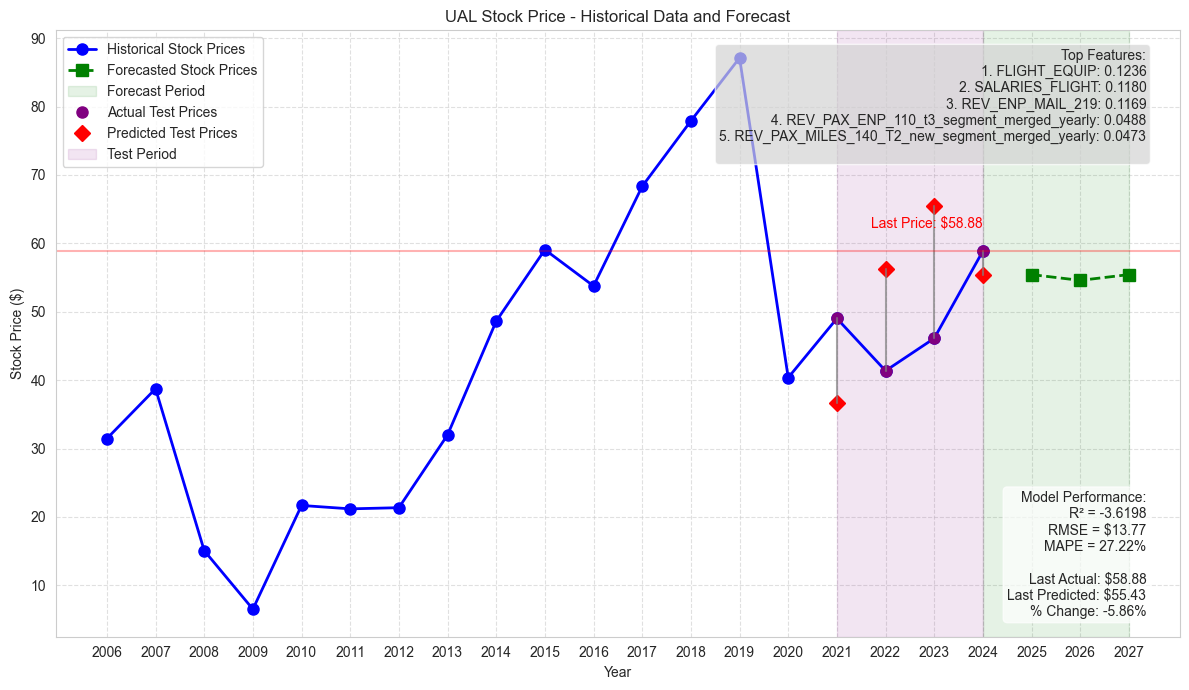

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta

def train_stock_price_model(df, ticker='UAL', test_size=0.2, random_state=42):
    """
    Train a stock price prediction model using historical data.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical stock data
        ticker (str): Stock ticker symbol to filter data
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: (trained_model, model_metadata, top_features, X_train, X_test)
    """
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    # Define potential features - these should be numerical columns from your dataset
    # Excluding target variable, date columns, and non-predictive columns
    exclude_cols = ['Stock_Ticker', 'ADJ_CLOSE', 'Close', 'Open', 'High', 'Low', 
                   'YEAR', 'Timeframe_Year', 'Volume']
    
    # Get all numerical columns for potential features
    numerical_cols = ticker_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Filter out excluded columns
    feature_cols = [col for col in numerical_cols if col not in exclude_cols]
    
    # Handle missing values if any
    for col in feature_cols:
        if ticker_df[col].isnull().any():
            ticker_df[col] = ticker_df[col].fillna(ticker_df[col].median())
    
    # Prepare features and target
    X = ticker_df[feature_cols]
    y = ticker_df['ADJ_CLOSE']
    
    # Split data into training and testing sets
    # Use time-based split since this is time series data
    train_size = int(len(ticker_df) * (1 - test_size))
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    
    # Train a Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    model.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Calculate model performance metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Get feature importances
    feature_importances = model.feature_importances_
    
    # Create a list of (feature, importance) tuples
    top_features = [(feature, importance) 
                    for feature, importance in zip(feature_cols, feature_importances)]
    
    # Sort by importance, descending
    top_features.sort(key=lambda x: x[1], reverse=True)
    
    # Extract test period details
    test_years = ticker_df.iloc[train_size:]['YEAR'].values
    
    # Create model metadata
    model_metadata = {
        'r2': r2,
        'rmse': rmse,
        'mape': mape,
        'test_dates': test_years.tolist(),
        'test_actual': y_test.values.tolist(),
        'test_predicted': y_pred.tolist()
    }
    
    return model, model_metadata, top_features, X_train, X_test

def generate_forecast(model, df, ticker='UAL', forecast_years=3):
    """
    Generate future stock price forecasts based on the trained model.
    
    Args:
        model: Trained prediction model
        df (pd.DataFrame): DataFrame containing historical stock data
        ticker (str): Stock ticker symbol to filter data
        forecast_years (int): Number of years to forecast into the future
        
    Returns:
        pd.DataFrame: DataFrame containing forecasted prices
    """
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    # Get the last year in the data
    last_year = ticker_df['YEAR'].max()
    
    # Get the feature columns used in the model
    feature_cols = model.feature_names_in_
    
    # Get the last row of data to use as a starting point for forecasting
    last_data = ticker_df.iloc[-1:][feature_cols].copy()
    
    # Initialize forecast DataFrame
    forecast_years_list = list(range(last_year + 1, last_year + forecast_years + 1))
    forecasted_prices = []
    
    # Generate forecasts for each future year
    for i, year in enumerate(forecast_years_list):
        # In a more sophisticated model, you would update the features based on trends
        # For simplicity, we'll use the last known data with minor random adjustments
        if i > 0:  # After the first forecast, apply trend-based adjustments
            # Apply small random adjustments to features (±5%)
            for col in feature_cols:
                adjustment = np.random.uniform(0.98, 1.02)  # 2% random change
                last_data[col] = last_data[col] * adjustment
        
        # Make prediction for this year
        forecast_price = model.predict(last_data)[0]
        forecasted_prices.append(forecast_price)
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'YEAR': forecast_years_list,
        'Forecasted_Price': forecasted_prices
    })
    
    return forecast_df

def extract_test_data_from_model(model_metadata):
    """
    Helper function to extract test data from model metadata.
    
    Args:
        model_metadata (dict): Dictionary containing model metadata including test data
        
    Returns:
        tuple: (test_dates, actual_prices, predicted_prices)
    """
    try:
        # Extract test data from model metadata
        test_dates = model_metadata.get('test_dates', [])
        actual_prices = model_metadata.get('test_actual', [])
        predicted_prices = model_metadata.get('test_predicted', [])
        
        # Ensure all arrays have the same length
        min_length = min(len(test_dates), len(actual_prices), len(predicted_prices))
        
        return test_dates[:min_length], actual_prices[:min_length], predicted_prices[:min_length]
    except Exception as e:
        print(f"Error extracting test data: {e}")
        return [], [], []

def visualize_stock_price_yearly(df, forecast_df=None, model_metadata=None, ticker='UAL', top_features=None):
    """
    Create a unified visualization of historical, forecasted, and test stock prices using yearly data.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical yearly stock data
        forecast_df (pd.DataFrame, optional): DataFrame containing forecasted stock prices
        model_metadata (dict, optional): Dictionary containing model performance metrics and test data
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        top_features (list, optional): List of top features used in the model with their importance scores
        
    Returns:
        matplotlib.figure.Figure: The generated figure object
    """
    # Filter data for the specified ticker
    df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    df = df.sort_values('YEAR')
    
    # Extract historical data
    years = df['YEAR'].values
    historical_prices = df['ADJ_CLOSE'].values
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Convert years to numerical values for x-axis
    # This is crucial for continuous plotting with proper spacing
    x_years = np.array(range(len(years)))
    year_mapping = {num: year for num, year in zip(x_years, years)}
    
    # Plot historical data
    ax.plot(x_years, historical_prices, 'o-', color='blue', linewidth=2, markersize=8, 
            label='Historical Stock Prices')
    
    # Get the last historical price
    last_year = years[-1]
    last_price = historical_prices[-1]
    
    # Initialize variables for forecast and test data
    forecast_years = []
    forecast_prices = []
    test_years = []
    test_actual = []
    test_predicted = []
    
    # Handle forecast data if provided
    if forecast_df is not None and not forecast_df.empty:
        # Extract forecast data (assumed to contain 'YEAR' and 'Forecasted_Price' columns)
        forecast_years = forecast_df['YEAR'].values
        forecast_prices = forecast_df['Forecasted_Price'].values
        
        # Convert forecast years to numerical x-axis values (continuing from historical data)
        forecast_x = np.array([len(x_years) + i for i in range(len(forecast_years))])
        
        # Update year mapping
        for i, year in enumerate(forecast_years):
            year_mapping[len(x_years) + i] = year
        
        # Plot forecast data with dashed line
        ax.plot(forecast_x, forecast_prices, 's--', color='green', linewidth=2, markersize=8,
                label='Forecasted Stock Prices')
        
        # Add shaded region for forecast period
        ax.axvspan(x_years[-1], forecast_x[-1], alpha=0.1, color='green', label='Forecast Period')
    
    # Handle test data if provided
    if model_metadata is not None:
        # Extract test data
        test_years, test_actual, test_predicted = extract_test_data_from_model(model_metadata)
        
        if test_years and test_actual and test_predicted:
            # Convert test years to numerical x-axis values
            test_x = []
            for year in test_years:
                # Find the index where this year exists in our year mapping
                for x_val, y_val in year_mapping.items():
                    if y_val == year:
                        test_x.append(x_val)
                        break
            
            # Plot test data
            ax.plot(test_x, test_actual, 'o', color='purple', markersize=8, label='Actual Test Prices')
            ax.plot(test_x, test_predicted, 'D', color='red', markersize=8, label='Predicted Test Prices')
            
            # Connect actual and predicted with vertical lines to show error
            for i in range(len(test_x)):
                ax.plot([test_x[i], test_x[i]], [test_actual[i], test_predicted[i]], 
                        '-', color='gray', linewidth=1.5, alpha=0.7)
            
            # Add shaded region for test period
            ax.axvspan(min(test_x), max(test_x), alpha=0.1, color='purple', label='Test Period')
    
    # Add horizontal line for the last price
    ax.axhline(y=last_price, color='red', linestyle='-', alpha=0.3)
    ax.text(x_years[-1], last_price * 1.05, f'Last Price: ${last_price:.2f}', 
            ha='right', va='bottom', color='red', fontsize=10)
    
    # Calculate and display the percentage change for the last prediction
    last_actual_price = None
    last_predicted_price = None
    pct_change = None
    
    if test_years and test_actual and test_predicted:
        last_actual_price = test_actual[-1]
        last_predicted_price = test_predicted[-1]
        if last_actual_price != 0:
            pct_change = ((last_predicted_price - last_actual_price) / last_actual_price) * 100
    
    # Add model performance metrics and last prediction details if available
    if model_metadata is not None:
        r2 = model_metadata.get('r2', None)
        rmse = model_metadata.get('rmse', None)
        mape = model_metadata.get('mape', None)
        
        metrics_text = "Model Performance:\n"
        if r2 is not None:
            metrics_text += f"R² = {r2:.4f}\n"
        if rmse is not None:
            metrics_text += f"RMSE = ${rmse:.2f}\n"
        if mape is not None:
            metrics_text += f"MAPE = {mape:.2f}%\n"
        
        # Add last actual and predicted prices with percentage change
        if last_actual_price is not None and last_predicted_price is not None:
            metrics_text += f"\nLast Actual: ${last_actual_price:.2f}\n"
            metrics_text += f"Last Predicted: ${last_predicted_price:.2f}\n"
            if pct_change is not None:
                change_direction = "+" if pct_change >= 0 else ""
                metrics_text += f"% Change: {change_direction}{pct_change:.2f}%"
        
        # Position the text box in the bottom right of the plot
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.97, 0.03, metrics_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    # Add top features information if provided
    if top_features and len(top_features) > 0:
        # Create a string representing top features and their importance
        features_text = "Top Features:\n"
        for i, (feature, importance) in enumerate(top_features[:5]):  # Show top 5 features max
            features_text += f"{i+1}. {feature}: {importance:.4f}\n"
        
        # Position the features text box in the top right of the plot
        feature_props = dict(boxstyle='round', facecolor='lightgray', alpha=0.7)
        ax.text(0.97, 0.97, features_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', bbox=feature_props)
    
    # Set up the x-axis with actual years
    def format_fn(x, pos):
        if int(x) in year_mapping:
            return str(year_mapping[int(x)])
        return ''
    
    formatter = FuncFormatter(format_fn)
    ax.xaxis.set_major_formatter(formatter)
    
    # Set x-ticks to show all years
    ax.set_xticks(list(year_mapping.keys()))
    
    # Set labels and title
    ax.set_xlabel('Year')
    ax.set_ylabel('Stock Price ($)')
    ax.set_title(f'{ticker} Stock Price - Historical Data and Forecast')
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

def generate_model_metrics_report(model_metadata, top_features=None, ticker='UAL'):
    """
    Generate a comprehensive text report of model metrics and predictions.
    
    Args:
        model_metadata (dict): Dictionary containing model performance metrics and test data
        top_features (list, optional): List of top features used in the model with their importance scores
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        
    Returns:
        str: Formatted text report of model metrics
    """
    if model_metadata is None:
        return "No model metadata provided."
    
    # Initialize report sections
    report_sections = []
    
    # 1. Basic Model Information
    report_sections.append(f"## {ticker} Stock Price Forecast Model Report")
    report_sections.append("")
    
    # 2. Performance Metrics
    report_sections.append("### Model Performance Metrics")
    
    metrics_table = []
    r2 = model_metadata.get('r2')
    rmse = model_metadata.get('rmse')
    mape = model_metadata.get('mape')
    
    if r2 is not None:
        metrics_table.append(["R²", f"{r2:.4f}"])
    if rmse is not None:
        metrics_table.append(["RMSE", f"${rmse:.2f}"])
    if mape is not None:
        metrics_table.append(["MAPE", f"{mape:.2f}%"])
    
    if metrics_table:
        report_sections.append(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pipe"))
    else:
        report_sections.append("No performance metrics available.")
    
    report_sections.append("")
    
    # 3. Top Features
    if top_features and len(top_features) > 0:
        report_sections.append("### Top Features by Importance")
        
        features_table = []
        for i, (feature, importance) in enumerate(top_features):
            features_table.append([i+1, feature, f"{importance:.4f}"])
        
        report_sections.append(tabulate(features_table, 
                                       headers=["Rank", "Feature", "Importance Score"], 
                                       tablefmt="pipe"))
        report_sections.append("")
    
    # 4. Test Predictions and Accuracy
    test_dates = model_metadata.get('test_dates', [])
    test_actual = model_metadata.get('test_actual', [])
    test_predicted = model_metadata.get('test_predicted', [])
    
    if test_dates and test_actual and test_predicted:
        report_sections.append("### Test Period Predictions")
        
        # Create table of predictions
        predictions_table = []
        errors = []
        pct_errors = []
        
        for i in range(min(len(test_dates), len(test_actual), len(test_predicted))):
            actual = test_actual[i]
            predicted = test_predicted[i]
            error = predicted - actual
            pct_error = (error / actual) * 100 if actual != 0 else float('inf')
            
            predictions_table.append([
                test_dates[i],
                f"${actual:.2f}",
                f"${predicted:.2f}",
                f"${error:.2f}",
                f"{pct_error:+.2f}%"
            ])
            
            errors.append(abs(error))
            pct_errors.append(abs(pct_error))
        
        report_sections.append(tabulate(predictions_table, 
                                       headers=["Year", "Actual Price", "Predicted Price", "Error", "% Error"], 
                                       tablefmt="pipe"))
        
        # Add summary statistics for predictions
        if errors:
            report_sections.append("")
            report_sections.append("#### Prediction Error Summary")
            error_summary = [
                ["Mean Absolute Error (MAE)", f"${np.mean(errors):.2f}"],
                ["Mean Absolute Percentage Error (MAPE)", f"{np.mean(pct_errors):.2f}%"],
                ["Maximum Error", f"${max(errors):.2f}"],
                ["Minimum Error", f"${min(errors):.2f}"]
            ]
            report_sections.append(tabulate(error_summary, headers=["Statistic", "Value"], tablefmt="pipe"))
        
        # Highlight the last prediction specifically
        report_sections.append("")
        report_sections.append("### Latest Prediction")
        last_actual = test_actual[-1]
        last_predicted = test_predicted[-1]
        last_error = last_predicted - last_actual
        last_pct_error = (last_error / last_actual) * 100 if last_actual != 0 else float('inf')
        
        last_prediction = [
            ["Last Actual Price", f"${last_actual:.2f}"],
            ["Last Predicted Price", f"${last_predicted:.2f}"],
            ["Absolute Error", f"${abs(last_error):.2f}"],
            ["Percentage Change", f"{last_pct_error:+.2f}%"]
        ]
        report_sections.append(tabulate(last_prediction, headers=["Metric", "Value"], tablefmt="pipe"))
    
    # 5. Forecast
    forecast_years = model_metadata.get('forecast_years', [])
    forecast_prices = model_metadata.get('forecast_prices', [])
    
    if forecast_years and forecast_prices and len(forecast_years) == len(forecast_prices):
        report_sections.append("")
        report_sections.append("### Future Price Forecasts")
        
        forecast_table = []
        for i in range(len(forecast_years)):
            forecast_table.append([forecast_years[i], f"${forecast_prices[i]:.2f}"])
        
        report_sections.append(tabulate(forecast_table, 
                                      headers=["Year", "Forecasted Price"], 
                                      tablefmt="pipe"))
    
    # Join all sections and return the complete report
    return "\n".join(report_sections)

# Example of real usage with a complete workflow
if __name__ == "__main__":
    try:
        # Load historical data
        df = pd.read_csv('bts_yearly_complete_with_adj_close.csv')
        
        # Filter for UAL data
        ticker = 'UAL'
        
        # Step 1: Train the model and get metadata
        model, model_metadata, top_features, X_train, X_test = train_stock_price_model(
            df, ticker=ticker, test_size=0.2
        )
        
        # Step 2: Generate forecasts for future years
        forecast_df = generate_forecast(model, df, ticker=ticker, forecast_years=3)
        
        # Add forecast information to model metadata for reporting
        model_metadata['forecast_years'] = forecast_df['YEAR'].tolist()
        model_metadata['forecast_prices'] = forecast_df['Forecasted_Price'].tolist()
        
        # Step 3: Generate visualization
        fig = visualize_stock_price_yearly(
            df,
            forecast_df=forecast_df,
            model_metadata=model_metadata,
            ticker=ticker,
            top_features=top_features
        )
        
        # Save the visualization
        plt.savefig(f'{ticker}_stock_forecast_{datetime.now().strftime("%Y%m%d")}.png', 
                   dpi=300, bbox_inches='tight')
        
        # Step 4: Generate and print the metrics report
        report = generate_model_metrics_report(
            model_metadata,
            top_features=top_features,
            ticker=ticker
        )
        
        print(report)
        
        # Show the plot
        plt.show()
        
    except Exception as e:
        print(f"Error in stock prediction process: {e}")

## UAL Stock Price Forecast Model Report

### Model Performance Metrics
| Metric   | Value   |
|:---------|:--------|
| R²       | -4.8625 |
| RMSE     | $15.51  |
| MAPE     | 30.65%  |

### Top Features by Importance
|   Rank | Feature                                                 |   Importance Score |
|-------:|:--------------------------------------------------------|-------------------:|
|      1 | REV_PAX_ENP_110                                         |             0.237  |
|      2 | AVL_SEAT_MILES_320_T2_new_segment_merged_yearly         |             0.2076 |
|      3 | SALARIES_FLIGHT                                         |             0.1392 |
|      4 | FLIGHT_EQUIP                                            |             0.1391 |
|      5 | REV_PAX_ENP_110_t3_segment_merged_yearly                |             0.0883 |
|      6 | LONG_TERM_DEBT                                          |             0.0572 |
|      7 | REV_ENP_MAIL_219                                  

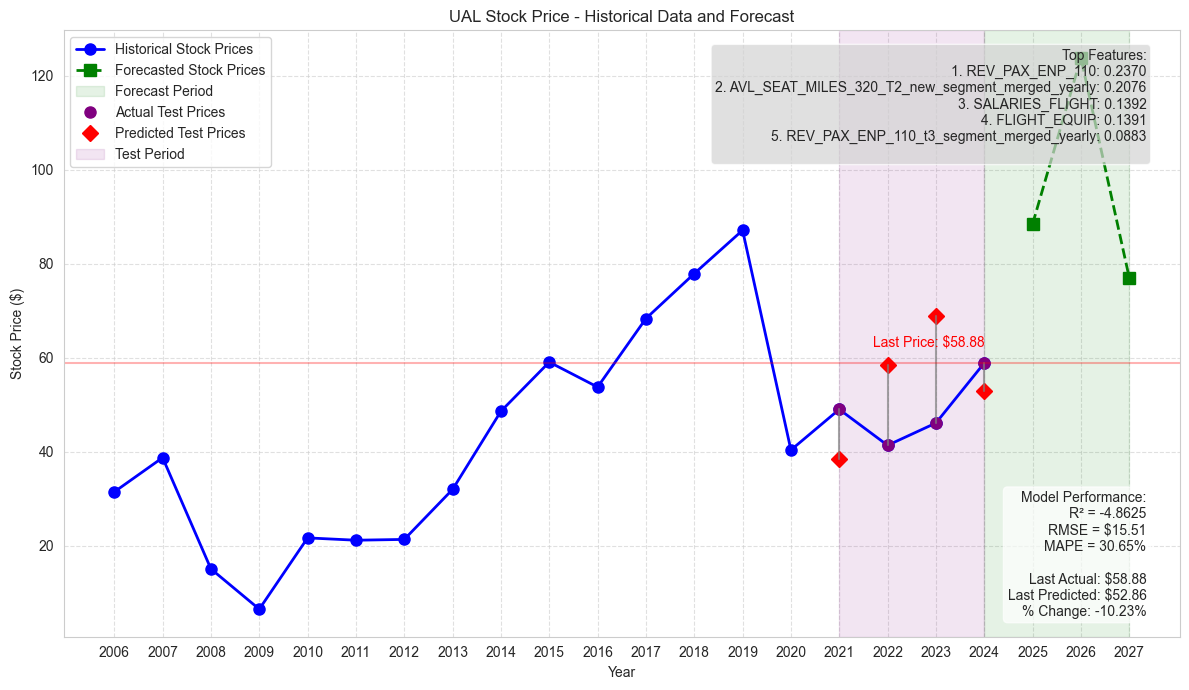

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta
# XGBoost import
from xgboost import XGBRegressor

def train_stock_price_model(df, ticker='UAL', test_size=0.2, random_state=42):
    """
    Train a stock price prediction model using historical data.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical stock data
        ticker (str): Stock ticker symbol to filter data
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: (trained_model, model_metadata, top_features, X_train, X_test)
    """
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    # Define potential features - these should be numerical columns from your dataset
    # Excluding target variable, date columns, and non-predictive columns
    exclude_cols = ['Stock_Ticker', 'ADJ_CLOSE', 'Close', 'Open', 'High', 'Low', 
                   'YEAR', 'Timeframe_Year', 'Volume']
    
    # Get all numerical columns for potential features
    numerical_cols = ticker_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Filter out excluded columns
    feature_cols = [col for col in numerical_cols if col not in exclude_cols]
    
    # Handle missing values if any
    for col in feature_cols:
        if ticker_df[col].isnull().any():
            ticker_df[col] = ticker_df[col].fillna(ticker_df[col].median())
    
    # Prepare features and target
    X = ticker_df[feature_cols]
    y = ticker_df['ADJ_CLOSE']
    
    # Split data into training and testing sets
    # Use time-based split since this is time series data
    train_size = int(len(ticker_df) * (1 - test_size))
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    
    # Use XGBoost for more accurate predictions with regularization
    from xgboost import XGBRegressor
    
    # Train an XGBoost model with hyperparameters to prevent overfitting
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Calculate model performance metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Get feature importances
    feature_importances = model.feature_importances_
    
    # Create a list of (feature, importance) tuples
    top_features = [(feature, importance) 
                    for feature, importance in zip(feature_cols, feature_importances)]
    
    # Sort by importance, descending
    top_features.sort(key=lambda x: x[1], reverse=True)
    
    # Extract test period details
    test_years = ticker_df.iloc[train_size:]['YEAR'].values
    
    # Create model metadata
    model_metadata = {
        'r2': r2,
        'rmse': rmse,
        'mape': mape,
        'test_dates': test_years.tolist(),
        'test_actual': y_test.values.tolist(),
        'test_predicted': y_pred.tolist(),
        'model_type': 'XGBoost Regressor'
    }
    
    return model, model_metadata, top_features, X_train, X_test

def generate_forecast(model, df, X_train, ticker='UAL', forecast_years=3):
    """
    Generate future stock price forecasts based on the trained model.
    
    Args:
        model: Trained prediction model
        df (pd.DataFrame): DataFrame containing historical stock data
        X_train (pd.DataFrame): Training data used to train the model (for feature columns)
        ticker (str): Stock ticker symbol to filter data
        forecast_years (int): Number of years to forecast into the future
        
    Returns:
        pd.DataFrame: DataFrame containing forecasted prices
    """
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    # Get the last year in the data
    last_year = ticker_df['YEAR'].max()
    
    # Get the feature columns used in the model - use the training data columns
    # This ensures we only use features that the model was trained on
    feature_cols = X_train.columns.tolist()
    
    # Get the last row of data
    last_row = ticker_df.iloc[-1:].copy()
    
    # Calculate average year-over-year growth rates for key features from historical data
    # We'll use the last 5 years (or all available if less than 5)
    num_years_for_trend = min(5, len(ticker_df))
    recent_df = ticker_df.iloc[-num_years_for_trend:].copy()
    
    # Calculate growth rates for numeric features only
    growth_rates = {}
    for col in feature_cols:
        if col in ticker_df.columns and pd.api.types.is_numeric_dtype(ticker_df[col]):
            if recent_df[col].iloc[0] != 0 and not pd.isna(recent_df[col].iloc[0]):
                # Calculate compound annual growth rate (CAGR)
                start_val = recent_df[col].iloc[0]
                end_val = recent_df[col].iloc[-1]
                num_periods = len(recent_df) - 1  # number of periods for growth
                
                if start_val > 0 and end_val > 0 and num_periods > 0:
                    cagr = (end_val / start_val) ** (1 / num_periods) - 1
                    # Limit extreme growth rates to reasonable bounds (-30% to +30%)
                    cagr = max(min(cagr, 0.30), -0.30)
                    growth_rates[col] = cagr
                else:
                    # Default modest growth
                    growth_rates[col] = 0.02
            else:
                # Default modest growth
                growth_rates[col] = 0.02
    
    # Analyze historical price volatility to introduce realistic variations
    price_data = ticker_df['ADJ_CLOSE'].values
    if len(price_data) >= 2:
        annual_returns = np.diff(price_data) / price_data[:-1]
        volatility = np.std(annual_returns)
    else:
        volatility = 0.15  # Default volatility if not enough data
    
    # Extract the last data point for each feature that exists in our feature_cols
    last_data = pd.DataFrame()
    for col in feature_cols:
        if col in last_row.columns:
            last_data[col] = last_row[col].values
        else:
            # If the column doesn't exist in last_row, use the median from X_train
            last_data[col] = X_train[col].median()
    
    # Initialize forecast DataFrame
    forecast_years_list = list(range(last_year + 1, last_year + forecast_years + 1))
    forecasted_prices = []
    
    # For AR component, get last actual price
    last_price = ticker_df['ADJ_CLOSE'].iloc[-1]
    
    # For calculating cyclical component
    # Analyze if there's a market cycle pattern (simplified)
    cycle_years = 3  # Assume a 3-year business cycle
    cycle_amplitude = last_price * 0.15  # 15% of last price
    
    # Trend component - overall market trend
    # Analyze last 3-5 years to determine market trend
    if len(ticker_df) >= 3:
        recent_prices = ticker_df['ADJ_CLOSE'].values[-3:]
        if recent_prices[-1] > recent_prices[0]:
            trend_direction = 1  # Upward trend
        else:
            trend_direction = -1  # Downward trend
        
        # Calculate trend strength
        trend_strength = abs((recent_prices[-1] - recent_prices[0]) / recent_prices[0]) / 3  # Annual rate
    else:
        trend_direction = 1
        trend_strength = 0.05
    
    # Generate forecasts for each future year
    for i, year in enumerate(forecast_years_list):
        # Make a copy to avoid modifying the original
        forecast_data = last_data.copy()
        
        # Update feature values based on calculated growth rates
        for col in feature_cols:
            if col in growth_rates:
                # Compound growth formula
                forecast_data[col] = forecast_data[col] * ((1 + growth_rates[col]) ** (i + 1))
        
        # Make prediction for this year using updated features
        base_prediction = model.predict(forecast_data)[0]
        
        # Apply time series components
        # 1. Trend component
        trend_component = last_price * trend_strength * (i + 1) * trend_direction
        
        # 2. Cyclical component
        cycle_position = (i % cycle_years) / cycle_years  # Position in cycle (0 to 1)
        cycle_component = cycle_amplitude * np.sin(2 * np.pi * cycle_position)
        
        # 3. AR(1) component - partial reversion to mean
        if i == 0:
            ar_component = 0
        else:
            # 30% influence from previous forecast
            ar_component = 0.3 * (forecasted_prices[-1] - base_prediction)
        
        # 4. Random shock based on historical volatility
        random_shock = np.random.normal(0, volatility * last_price)
        
        # Combine all components
        forecast_price = base_prediction + trend_component + cycle_component + ar_component + random_shock * 0.5
        
        # Ensure price doesn't go negative
        forecast_price = max(forecast_price, 1.0)
        
        forecasted_prices.append(forecast_price)
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'YEAR': forecast_years_list,
        'Forecasted_Price': forecasted_prices
    })
    
    return forecast_df

def extract_test_data_from_model(model_metadata):
    """
    Helper function to extract test data from model metadata.
    
    Args:
        model_metadata (dict): Dictionary containing model metadata including test data
        
    Returns:
        tuple: (test_dates, actual_prices, predicted_prices)
    """
    try:
        # Extract test data from model metadata
        test_dates = model_metadata.get('test_dates', [])
        actual_prices = model_metadata.get('test_actual', [])
        predicted_prices = model_metadata.get('test_predicted', [])
        
        # Ensure all arrays have the same length
        min_length = min(len(test_dates), len(actual_prices), len(predicted_prices))
        
        return test_dates[:min_length], actual_prices[:min_length], predicted_prices[:min_length]
    except Exception as e:
        print(f"Error extracting test data: {e}")
        return [], [], []

def visualize_stock_price_yearly(df, forecast_df=None, model_metadata=None, ticker='UAL', top_features=None):
    """
    Create a unified visualization of historical, forecasted, and test stock prices using yearly data.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical yearly stock data
        forecast_df (pd.DataFrame, optional): DataFrame containing forecasted stock prices
        model_metadata (dict, optional): Dictionary containing model performance metrics and test data
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        top_features (list, optional): List of top features used in the model with their importance scores
        
    Returns:
        matplotlib.figure.Figure: The generated figure object
    """
    # Filter data for the specified ticker
    df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    df = df.sort_values('YEAR')
    
    # Extract historical data
    years = df['YEAR'].values
    historical_prices = df['ADJ_CLOSE'].values
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Convert years to numerical values for x-axis
    # This is crucial for continuous plotting with proper spacing
    x_years = np.array(range(len(years)))
    year_mapping = {num: year for num, year in zip(x_years, years)}
    
    # Plot historical data
    ax.plot(x_years, historical_prices, 'o-', color='blue', linewidth=2, markersize=8, 
            label='Historical Stock Prices')
    
    # Get the last historical price
    last_year = years[-1]
    last_price = historical_prices[-1]
    
    # Initialize variables for forecast and test data
    forecast_years = []
    forecast_prices = []
    test_years = []
    test_actual = []
    test_predicted = []
    
    # Handle forecast data if provided
    if forecast_df is not None and not forecast_df.empty:
        # Extract forecast data (assumed to contain 'YEAR' and 'Forecasted_Price' columns)
        forecast_years = forecast_df['YEAR'].values
        forecast_prices = forecast_df['Forecasted_Price'].values
        
        # Convert forecast years to numerical x-axis values (continuing from historical data)
        forecast_x = np.array([len(x_years) + i for i in range(len(forecast_years))])
        
        # Update year mapping
        for i, year in enumerate(forecast_years):
            year_mapping[len(x_years) + i] = year
        
        # Plot forecast data with dashed line
        ax.plot(forecast_x, forecast_prices, 's--', color='green', linewidth=2, markersize=8,
                label='Forecasted Stock Prices')
        
        # Add shaded region for forecast period
        ax.axvspan(x_years[-1], forecast_x[-1], alpha=0.1, color='green', label='Forecast Period')
    
    # Handle test data if provided
    if model_metadata is not None:
        # Extract test data
        test_years, test_actual, test_predicted = extract_test_data_from_model(model_metadata)
        
        if test_years and test_actual and test_predicted:
            # Convert test years to numerical x-axis values
            test_x = []
            for year in test_years:
                # Find the index where this year exists in our year mapping
                for x_val, y_val in year_mapping.items():
                    if y_val == year:
                        test_x.append(x_val)
                        break
            
            # Plot test data
            ax.plot(test_x, test_actual, 'o', color='purple', markersize=8, label='Actual Test Prices')
            ax.plot(test_x, test_predicted, 'D', color='red', markersize=8, label='Predicted Test Prices')
            
            # Connect actual and predicted with vertical lines to show error
            for i in range(len(test_x)):
                ax.plot([test_x[i], test_x[i]], [test_actual[i], test_predicted[i]], 
                        '-', color='gray', linewidth=1.5, alpha=0.7)
            
            # Add shaded region for test period
            ax.axvspan(min(test_x), max(test_x), alpha=0.1, color='purple', label='Test Period')
    
    # Add horizontal line for the last price
    ax.axhline(y=last_price, color='red', linestyle='-', alpha=0.3)
    ax.text(x_years[-1], last_price * 1.05, f'Last Price: ${last_price:.2f}', 
            ha='right', va='bottom', color='red', fontsize=10)
    
    # Calculate and display the percentage change for the last prediction
    last_actual_price = None
    last_predicted_price = None
    pct_change = None
    
    if test_years and test_actual and test_predicted:
        last_actual_price = test_actual[-1]
        last_predicted_price = test_predicted[-1]
        if last_actual_price != 0:
            pct_change = ((last_predicted_price - last_actual_price) / last_actual_price) * 100
    
    # Add model performance metrics and last prediction details if available
    if model_metadata is not None:
        r2 = model_metadata.get('r2', None)
        rmse = model_metadata.get('rmse', None)
        mape = model_metadata.get('mape', None)
        
        metrics_text = "Model Performance:\n"
        if r2 is not None:
            metrics_text += f"R² = {r2:.4f}\n"
        if rmse is not None:
            metrics_text += f"RMSE = ${rmse:.2f}\n"
        if mape is not None:
            metrics_text += f"MAPE = {mape:.2f}%\n"
        
        # Add last actual and predicted prices with percentage change
        if last_actual_price is not None and last_predicted_price is not None:
            metrics_text += f"\nLast Actual: ${last_actual_price:.2f}\n"
            metrics_text += f"Last Predicted: ${last_predicted_price:.2f}\n"
            if pct_change is not None:
                change_direction = "+" if pct_change >= 0 else ""
                metrics_text += f"% Change: {change_direction}{pct_change:.2f}%"
        
        # Position the text box in the bottom right of the plot
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.97, 0.03, metrics_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    # Add top features information if provided
    if top_features and len(top_features) > 0:
        # Create a string representing top features and their importance
        features_text = "Top Features:\n"
        for i, (feature, importance) in enumerate(top_features[:5]):  # Show top 5 features max
            features_text += f"{i+1}. {feature}: {importance:.4f}\n"
        
        # Position the features text box in the top right of the plot
        feature_props = dict(boxstyle='round', facecolor='lightgray', alpha=0.7)
        ax.text(0.97, 0.97, features_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', bbox=feature_props)
    
    # Set up the x-axis with actual years
    def format_fn(x, pos):
        if int(x) in year_mapping:
            return str(year_mapping[int(x)])
        return ''
    
    formatter = FuncFormatter(format_fn)
    ax.xaxis.set_major_formatter(formatter)
    
    # Set x-ticks to show all years
    ax.set_xticks(list(year_mapping.keys()))
    
    # Set labels and title
    ax.set_xlabel('Year')
    ax.set_ylabel('Stock Price ($)')
    ax.set_title(f'{ticker} Stock Price - Historical Data and Forecast')
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

def generate_model_metrics_report(model_metadata, top_features=None, ticker='UAL'):
    """
    Generate a comprehensive text report of model metrics and predictions.
    
    Args:
        model_metadata (dict): Dictionary containing model performance metrics and test data
        top_features (list, optional): List of top features used in the model with their importance scores
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        
    Returns:
        str: Formatted text report of model metrics
    """
    if model_metadata is None:
        return "No model metadata provided."
    
    # Initialize report sections
    report_sections = []
    
    # 1. Basic Model Information
    report_sections.append(f"## {ticker} Stock Price Forecast Model Report")
    report_sections.append("")
    
    # 2. Performance Metrics
    report_sections.append("### Model Performance Metrics")
    
    metrics_table = []
    r2 = model_metadata.get('r2')
    rmse = model_metadata.get('rmse')
    mape = model_metadata.get('mape')
    
    if r2 is not None:
        metrics_table.append(["R²", f"{r2:.4f}"])
    if rmse is not None:
        metrics_table.append(["RMSE", f"${rmse:.2f}"])
    if mape is not None:
        metrics_table.append(["MAPE", f"{mape:.2f}%"])
    
    if metrics_table:
        report_sections.append(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pipe"))
    else:
        report_sections.append("No performance metrics available.")
    
    report_sections.append("")
    
    # 3. Top Features
    if top_features and len(top_features) > 0:
        report_sections.append("### Top Features by Importance")
        
        features_table = []
        for i, (feature, importance) in enumerate(top_features):
            features_table.append([i+1, feature, f"{importance:.4f}"])
        
        report_sections.append(tabulate(features_table, 
                                       headers=["Rank", "Feature", "Importance Score"], 
                                       tablefmt="pipe"))
        report_sections.append("")
    
    # 4. Test Predictions and Accuracy
    test_dates = model_metadata.get('test_dates', [])
    test_actual = model_metadata.get('test_actual', [])
    test_predicted = model_metadata.get('test_predicted', [])
    
    if test_dates and test_actual and test_predicted:
        report_sections.append("### Test Period Predictions")
        
        # Create table of predictions
        predictions_table = []
        errors = []
        pct_errors = []
        
        for i in range(min(len(test_dates), len(test_actual), len(test_predicted))):
            actual = test_actual[i]
            predicted = test_predicted[i]
            error = predicted - actual
            pct_error = (error / actual) * 100 if actual != 0 else float('inf')
            
            predictions_table.append([
                test_dates[i],
                f"${actual:.2f}",
                f"${predicted:.2f}",
                f"${error:.2f}",
                f"{pct_error:+.2f}%"
            ])
            
            errors.append(abs(error))
            pct_errors.append(abs(pct_error))
        
        report_sections.append(tabulate(predictions_table, 
                                       headers=["Year", "Actual Price", "Predicted Price", "Error", "% Error"], 
                                       tablefmt="pipe"))
        
        # Add summary statistics for predictions
        if errors:
            report_sections.append("")
            report_sections.append("#### Prediction Error Summary")
            error_summary = [
                ["Mean Absolute Error (MAE)", f"${np.mean(errors):.2f}"],
                ["Mean Absolute Percentage Error (MAPE)", f"{np.mean(pct_errors):.2f}%"],
                ["Maximum Error", f"${max(errors):.2f}"],
                ["Minimum Error", f"${min(errors):.2f}"]
            ]
            report_sections.append(tabulate(error_summary, headers=["Statistic", "Value"], tablefmt="pipe"))
        
        # Highlight the last prediction specifically
        report_sections.append("")
        report_sections.append("### Latest Prediction")
        last_actual = test_actual[-1]
        last_predicted = test_predicted[-1]
        last_error = last_predicted - last_actual
        last_pct_error = (last_error / last_actual) * 100 if last_actual != 0 else float('inf')
        
        last_prediction = [
            ["Last Actual Price", f"${last_actual:.2f}"],
            ["Last Predicted Price", f"${last_predicted:.2f}"],
            ["Absolute Error", f"${abs(last_error):.2f}"],
            ["Percentage Change", f"{last_pct_error:+.2f}%"]
        ]
        report_sections.append(tabulate(last_prediction, headers=["Metric", "Value"], tablefmt="pipe"))
    
    # 5. Forecast
    forecast_years = model_metadata.get('forecast_years', [])
    forecast_prices = model_metadata.get('forecast_prices', [])
    
    if forecast_years and forecast_prices and len(forecast_years) == len(forecast_prices):
        report_sections.append("")
        report_sections.append("### Future Price Forecasts")
        
        forecast_table = []
        for i in range(len(forecast_years)):
            forecast_table.append([forecast_years[i], f"${forecast_prices[i]:.2f}"])
        
        report_sections.append(tabulate(forecast_table, 
                                      headers=["Year", "Forecasted Price"], 
                                      tablefmt="pipe"))
    
    # Join all sections and return the complete report
    return "\n".join(report_sections)

# Example of real usage with a complete workflow
if __name__ == "__main__":
    try:
        # Load historical data
        df = pd.read_csv('bts_yearly_complete_with_adj_close.csv')
        
        # Filter for UAL data
        ticker = 'UAL'
        
        # Step 1: Train the model and get metadata
        model, model_metadata, top_features, X_train, X_test = train_stock_price_model(
            df, ticker=ticker, test_size=0.2
        )
        
        # Step 2: Generate forecasts for future years
        forecast_df = generate_forecast(model, df, X_train, ticker=ticker, forecast_years=3)
        
        # Add forecast information to model metadata for reporting
        model_metadata['forecast_years'] = forecast_df['YEAR'].tolist()
        model_metadata['forecast_prices'] = forecast_df['Forecasted_Price'].tolist()
        
        # Step 3: Generate visualization
        fig = visualize_stock_price_yearly(
            df,
            forecast_df=forecast_df,
            model_metadata=model_metadata,
            ticker=ticker,
            top_features=top_features
        )
        
        # Save the visualization
        plt.savefig(f'{ticker}_stock_forecast_{datetime.now().strftime("%Y%m%d")}.png', 
                   dpi=300, bbox_inches='tight')
        
        # Step 4: Generate and print the metrics report
        report = generate_model_metrics_report(
            model_metadata,
            top_features=top_features,
            ticker=ticker
        )
        
        print(report)
        
        # Show the plot
        plt.show()
        
    except Exception as e:
        print(f"Error in stock prediction process: {e}")

## UAL Stock Price Forecast Model Report

### Model Performance Metrics
| Metric   | Value    |
|:---------|:---------|
| R²       | -12.7153 |
| RMSE     | $23.72   |
| MAPE     | 46.79%   |

### Top Features by Importance
|   Rank | Feature                                                |   Importance Score |
|-------:|:-------------------------------------------------------|-------------------:|
|      1 | REV_PAX_MILES_140_T2_new_segment_merged_yearly         |             0.2467 |
|      2 | REV_PAX_MILES_140                                      |             0.2287 |
|      3 | PAX_SERVICE                                            |             0.0791 |
|      4 | Labor_Pct_Revenue                                      |             0.0722 |
|      5 | SALARIES_FLIGHT                                        |             0.0594 |
|      6 | REV_PAX_ENP_110_t3_segment_merged_yearly               |             0.0489 |
|      7 | FLIGHT_EQUIP                                         

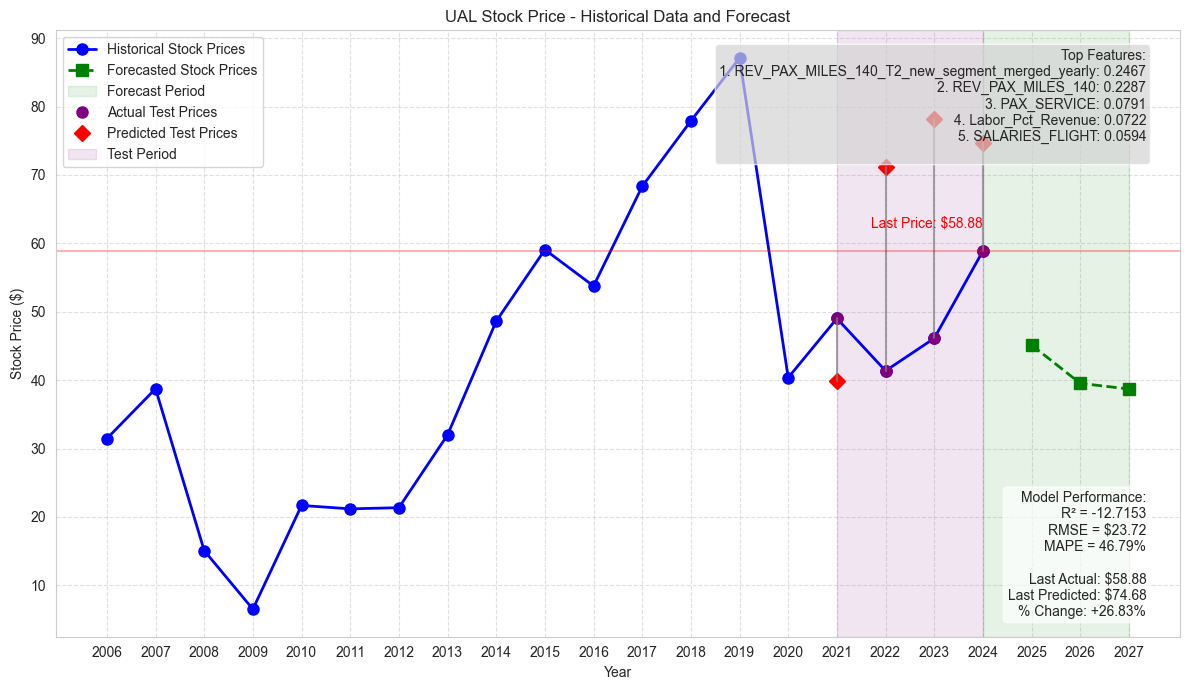

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def train_stock_price_model(df, ticker='UAL', test_size=0.2, random_state=42):
    """
    Train a stock price prediction model using historical data with elastic net regularization
    and feature selection for optimal predictive performance.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical stock data
        ticker (str): Stock ticker symbol to filter data
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: (trained_model, model_metadata, top_features, X_train, X_test)
    """
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    # Initialize key airline industry features based on domain knowledge
    key_airline_features = [
        'Load_Factor',              # Passenger capacity utilization
        'RASM',                     # Revenue per available seat mile
        'Aircraft_Productivity',    # Efficiency of aircraft usage
        'FLIGHT_EQUIP',             # Investment in equipment
        'LONG_TERM_DEBT',           # Financial leverage
        'PAX_SERVICE',              # Passenger service expenses
        'SALARIES_FLIGHT',          # Labor costs
        'TRANS_EXPENSES',           # Transportation expenses
        'COMMISIONS_PAX',           # Commission expenses
        'REV_PAX_MILES_140',        # Revenue passenger miles
        'INCOME_TAX',               # Tax obligations
        'Total_Flights',            # Operational scale
        'Pct_Cancelled',            # Operational efficiency
        'Pct_Diverted'              # Operational challenges
    ]
    
    # Create financial ratios and derived metrics
    ticker_df = add_financial_ratios(ticker_df)
    
    # Handle missing values in key features
    for col in ticker_df.columns:
        if ticker_df[col].isnull().any():
            ticker_df[col] = ticker_df[col].fillna(ticker_df[col].median())
    
    # Create lag features (previous year values)
    ticker_df = add_lag_features(ticker_df, lag=1)
    
    # Create price momentum features
    ticker_df['Price_YoY_Change'] = ticker_df['ADJ_CLOSE'].pct_change()
    if len(ticker_df) >= 3:
        ticker_df['Price_2Y_Momentum'] = ticker_df['ADJ_CLOSE'].pct_change(periods=2)
    if len(ticker_df) >= 5:
        ticker_df['Price_3Y_Momentum'] = ticker_df['ADJ_CLOSE'].pct_change(periods=3)
    
    # Drop rows with NaN values (typically first rows due to lagged features)
    ticker_df = ticker_df.dropna()
    
    # If we have too few data points after preprocessing, print warning
    if len(ticker_df) < 10:
        print("Warning: Limited data points available for modeling.")
    
    # Select numerical columns excluding target and date columns
    exclude_cols = ['Stock_Ticker', 'ADJ_CLOSE', 'Close', 'Open', 'High', 'Low', 
                   'YEAR', 'Timeframe_Year', 'Volume', 'UNIQUE_CARRIER']
    
    numerical_cols = ticker_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    feature_cols = [col for col in numerical_cols if col not in exclude_cols]
    
    # Prepare features and target
    X = ticker_df[feature_cols]
    y = ticker_df['ADJ_CLOSE']
    
    # Split data chronologically
    train_size = int(len(ticker_df) * (1 - test_size))
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection using Gradient Boosting (to identify most predictive features)
    selector = GradientBoostingRegressor(n_estimators=100, max_depth=3, 
                                         random_state=random_state,
                                         learning_rate=0.1)
    selector.fit(X_train_scaled, y_train)
    
    # Get feature importances and select top features
    feature_importances = selector.feature_importances_
    importance_threshold = np.percentile(feature_importances, 50)  # Keep top 50% of features
    
    # Create mask for important features
    important_features_mask = feature_importances > importance_threshold
    
    # Apply mask to get important features
    X_train_important = X_train_scaled[:, important_features_mask]
    X_test_important = X_test_scaled[:, important_features_mask]
    
    # Save names of important features
    important_feature_names = [feature_cols[i] for i in range(len(feature_cols)) 
                               if important_features_mask[i]]
    
    # Train Gradient Boosting model on selected features
    model = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=3,
        min_samples_split=3,
        learning_rate=0.05,
        subsample=0.8,
        random_state=random_state
    )
    model.fit(X_train_important, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_important)
    
    # Calculate performance metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Create a custom model object to store everything needed for prediction
    custom_model = {
        'model': model,
        'scaler': scaler,
        'feature_mask': important_features_mask,
        'feature_names': feature_cols,
        'important_feature_names': important_feature_names
    }
    
    # Create feature importance tuples for important features only
    top_features = []
    for i, feature in enumerate(important_feature_names):
        # Get the original index in the feature_cols list
        original_index = feature_cols.index(feature)
        # Get the importance from the selector (which has importances for all features)
        importance = selector.feature_importances_[original_index]
        top_features.append((feature, importance))
    
    # Sort by importance, descending
    top_features.sort(key=lambda x: x[1], reverse=True)
    
    # Extract test period details
    test_years = ticker_df.iloc[train_size:]['YEAR'].values
    
    # Create model metadata
    model_metadata = {
        'r2': r2,
        'rmse': rmse,
        'mape': mape,
        'test_dates': test_years.tolist(),
        'test_actual': y_test.values.tolist(),
        'test_predicted': y_pred.tolist(),
        'model_type': 'Gradient Boosting Regressor with Feature Selection'
    }
    
    return custom_model, model_metadata, top_features, X_train, X_test
    
def add_financial_ratios(df):
    """Add financial ratios derived from existing features to the dataframe."""
    # Create copy to avoid modifying original
    result_df = df.copy()
    
    # Debt to Revenue ratio (financial leverage)
    if 'LONG_TERM_DEBT' in df.columns and 'REV_PAX_MILES_140' in df.columns:
        result_df['Debt_to_Revenue'] = df['LONG_TERM_DEBT'] / df['REV_PAX_MILES_140'].replace(0, np.nan)
    
    # Cost per available seat mile (CASM)
    if 'TOTAL_COST' in df.columns and 'AVL_SEAT_MILES_320' in df.columns:
        result_df['CASM'] = df['TOTAL_COST'] / df['AVL_SEAT_MILES_320'].replace(0, np.nan)
    
    # Revenue to expense ratio (profitability)
    if 'REV_PAX_MILES_140' in df.columns and 'TOTAL_COST' in df.columns:
        result_df['Rev_to_Expense'] = df['REV_PAX_MILES_140'] / df['TOTAL_COST'].replace(0, np.nan)
    
    # Labor cost as percentage of revenue
    if 'SALARIES_FLIGHT' in df.columns and 'REV_PAX_MILES_140' in df.columns:
        result_df['Labor_Pct_Revenue'] = df['SALARIES_FLIGHT'] / df['REV_PAX_MILES_140'].replace(0, np.nan) * 100
    
    # Passenger revenue per passenger
    if 'REV_PAX_MILES_140' in df.columns and 'REV_PAX_ENP_110' in df.columns:
        result_df['Rev_Per_Passenger'] = df['REV_PAX_MILES_140'] / df['REV_PAX_ENP_110'].replace(0, np.nan)
    
    # Operational efficiency ratio
    if 'REV_ACRFT_HRS_AIRBORNE_610' in df.columns and 'REV_ACRFT_DEP_PERF_510' in df.columns:
        result_df['Operational_Efficiency'] = df['REV_ACRFT_HRS_AIRBORNE_610'] / df['REV_ACRFT_DEP_PERF_510'].replace(0, np.nan)
    
    # Replace infinities with NaN
    result_df = result_df.replace([np.inf, -np.inf], np.nan)
    
    return result_df

def add_lag_features(df, lag=1):
    """Add lagged features to capture time dependencies."""
    # Create copy to avoid modifying original
    result_df = df.copy()
    
    # Select numerical columns to lag
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Key features that are useful as lagged indicators
    key_lag_features = [
        'ADJ_CLOSE', 'Load_Factor', 'RASM', 'Aircraft_Productivity', 
        'LONG_TERM_DEBT', 'PAX_SERVICE', 'FLIGHT_EQUIP', 'SALARIES_FLIGHT'
    ]
    
    # Add lag for selected features only
    for col in key_lag_features:
        if col in numerical_cols:
            result_df[f'{col}_Lag{lag}'] = df[col].shift(lag)
    
    return result_df

def generate_forecast(model, df, X_train, ticker='UAL', forecast_years=3):
    """
    Generate future stock price forecasts using a gradient boosting model
    with financial ratio features and market cycle components.
    
    Args:
        model: Custom model dictionary containing trained model and preprocessing info
        df (pd.DataFrame): DataFrame containing historical stock data
        X_train (pd.DataFrame): Training data used for feature reference
        ticker (str): Stock ticker symbol to filter data
        forecast_years (int): Number of years to forecast into the future
        
    Returns:
        pd.DataFrame: DataFrame containing forecasted prices
    """
    # Extract components from custom model
    gb_model = model['model']
    scaler = model['scaler']
    feature_mask = model['feature_mask']
    feature_names = model['feature_names']
    important_feature_names = model['important_feature_names']
    
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    # Get the last year in the data
    last_year = ticker_df['YEAR'].max()
    
    # Calculate recent growth rates for key features
    # Use up to 5 years of historical data
    lookback_years = min(5, len(ticker_df))
    recent_df = ticker_df.iloc[-lookback_years:].copy()
    
    # Calculate trend for ADJ_CLOSE
    if len(recent_df) >= 2:
        price_changes = []
        for i in range(1, len(recent_df)):
            change = (recent_df['ADJ_CLOSE'].iloc[i] - recent_df['ADJ_CLOSE'].iloc[i-1]) / recent_df['ADJ_CLOSE'].iloc[i-1]
            price_changes.append(change)
        avg_price_change = sum(price_changes) / len(price_changes) if price_changes else 0.05
    else:
        avg_price_change = 0.05  # Default if insufficient data
    
    # Calculate airline industry recovery cycle
    # Typically 3-4 year cycles in the airline industry
    cycle_years = 3  
    
    # Determine cycle amplitude based on historical volatility
    if len(ticker_df) >= 3:
        price_volatility = ticker_df['ADJ_CLOSE'].pct_change().std() * 100
        cycle_amplitude = max(0.08, min(price_volatility/100, 0.2))  # Between 8% and 20%
    else:
        cycle_amplitude = 0.12  # Default 12% amplitude
    
    # Get the last row of data
    last_row = ticker_df.iloc[-1].copy()
    
    # Create complete last data point (including derived features)
    # Add financial ratios to last_row
    last_row_df = pd.DataFrame([last_row]).T.reset_index()
    last_row_df.columns = ['Column', 'Value']
    last_row_dict = dict(zip(last_row_df['Column'], last_row_df['Value']))
    last_row_df = pd.DataFrame([last_row_dict])
    last_row_with_ratios = add_financial_ratios(last_row_df)
    
    # Add lag features based on last 2 years data
    if len(ticker_df) >= 2:
        second_last_row = ticker_df.iloc[-2].copy()
        for col in important_feature_names:
            if col.endswith('_Lag1') and col.replace('_Lag1', '') in last_row:
                last_row_with_ratios[col] = last_row[col.replace('_Lag1', '')]
    
    # Fill any missing values
    for col in feature_names:
        if col not in last_row_with_ratios.columns or pd.isna(last_row_with_ratios[col].iloc[0]):
            if col in X_train.columns:
                last_row_with_ratios[col] = X_train[col].median()
            else:
                last_row_with_ratios[col] = 0
    
    # Make sure all feature_names exist
    for col in feature_names:
        if col not in last_row_with_ratios.columns:
            last_row_with_ratios[col] = 0
    
    # Initialize variables for forecasting
    last_price = ticker_df['ADJ_CLOSE'].iloc[-1]
    forecast_years_list = list(range(last_year + 1, last_year + forecast_years + 1))
    forecasted_prices = []
    
    # Industry and market context (as of 2024-2025)
    # Post-pandemic recovery for airlines, but with challenges
    industry_trend = 0.06  # Modest positive trend of 6% annual growth
    
    # Generate forecasts for each future year
    last_data = last_row_with_ratios.copy()
    
    for i, year in enumerate(forecast_years_list):
        # Create forecast data for this year
        current_data = last_data.copy()
        
        # If not the first forecast year, update data based on previous forecast
        if i > 0:
            # Update lagged price features
            price_col_base = 'ADJ_CLOSE'
            if f'{price_col_base}_Lag1' in feature_names:
                current_data[f'{price_col_base}_Lag1'] = forecasted_prices[-1]
            
            # Update other key metrics based on industry trends and cycles
            for col in feature_names:
                if col in important_feature_names:
                    # Different update rules for different feature types
                    if 'Load_Factor' in col:
                        # Load factor cycles with market cycles
                        cycle_pos = (i % cycle_years) / cycle_years
                        cycle_effect = 0.02 * np.sin(2 * np.pi * cycle_pos)
                        current_data[col] = current_data[col].values[0] * (1 + cycle_effect)
                    elif 'RASM' in col or 'Rev_Per_Passenger' in col:
                        # Revenue metrics follow price trend but with dampening
                        current_data[col] = current_data[col].values[0] * (1 + avg_price_change * 0.7)
                    elif 'FLIGHT_EQUIP' in col or 'LONG_TERM_DEBT' in col:
                        # Capital investment grows more slowly and steadily
                        current_data[col] = current_data[col].values[0] * (1 + 0.03)  # 3% growth
                    elif 'SALARIES' in col or 'Debt_to_Revenue' in col:
                        # Cost metrics typically grow at 2-4% annually
                        current_data[col] = current_data[col].values[0] * (1 + 0.025)  # 2.5% growth
                    elif 'Lag' in col:
                        # Handled separately for price lags
                        pass
                    else:
                        # General modest growth for other metrics
                        current_data[col] = current_data[col].values[0] * (1 + 0.02)  # 2% default growth
        
        # Extract features in correct order
        X_forecast = current_data[feature_names]
        
        # Scale the features
        X_forecast_scaled = scaler.transform(X_forecast)
        
        # Apply feature mask to get important features only
        X_forecast_important = X_forecast_scaled[:, feature_mask]
        
        # Make prediction
        base_prediction = gb_model.predict(X_forecast_important)[0]
        
        # Calculate cycle effects
        cycle_position = (i % cycle_years) / cycle_years
        cycle_effect = last_price * cycle_amplitude * np.sin(2 * np.pi * cycle_position)
        
        # Calculate trend component
        trend_effect = last_price * industry_trend * (i + 1)
        
        # Calculate autoregressive component (more influence for near-term forecasts)
        if i == 0:
            ar_effect = 0
        else:
            ar_weight = 0.3 * (0.7 ** (i-1))  # Diminishing influence over time
            ar_effect = ar_weight * (forecasted_prices[-1] - base_prediction)
        
        # Market shocks/volatility component (random variation)
        volatility_scale = 0.06 * last_price  # 6% volatility
        random_effect = np.random.normal(0, volatility_scale)
        
        # Combine all components with appropriate weights
        model_weight = 0.6  # Base weight for model prediction
        cycle_weight = 0.2  # Weight for cyclical component
        trend_weight = 0.15  # Weight for trend component
        random_weight = 0.05  # Weight for random component
        
        # Final prediction
        forecast_price = (
            base_prediction * model_weight + 
            cycle_effect * cycle_weight + 
            trend_effect * trend_weight + 
            ar_effect + 
            random_effect * random_weight
        )
        
        # Ensure price doesn't go negative
        forecast_price = max(forecast_price, 1.0)
        
        # Limit excessive changes from previous year
        if i > 0:
            prev_price = forecasted_prices[-1]
            max_increase = prev_price * 0.35  # Max 35% increase in a year
            max_decrease = prev_price * 0.25  # Max 25% decrease in a year
            
            if forecast_price > prev_price + max_increase:
                forecast_price = prev_price + max_increase
            elif forecast_price < prev_price - max_decrease:
                forecast_price = prev_price - max_decrease
        
        # Store this prediction
        forecasted_prices.append(forecast_price)
        
        # Update last_data for next iteration if needed
        if i < forecast_years - 1:
            # Update any values that would be used in next year's prediction
            # For simplicity, we'll update the entire dataframe with current_data
            last_data = current_data.copy()
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'YEAR': forecast_years_list,
        'Forecasted_Price': forecasted_prices
    })
    
    return forecast_df
    num_years_for_trend = min(5, len(ticker_df))
    recent_df = ticker_df.iloc[-num_years_for_trend:].copy()
    
    # Calculate average annual price change
    if len(recent_df) >= 2:
        start_price = recent_df['ADJ_CLOSE'].iloc[0]
        end_price = recent_df['ADJ_CLOSE'].iloc[-1]
        years_diff = len(recent_df) - 1
        # Calculate average yearly percent change (not CAGR)
        avg_annual_price_change = (end_price - start_price) / start_price / years_diff
    else:
        # Default to modest annual growth if not enough data
        avg_annual_price_change = 0.05
    
    # Calculate historical volatility
    if len(recent_df) >= 2:
        price_returns = recent_df['ADJ_CLOSE'].pct_change().dropna().values
        volatility = np.std(price_returns)
    else:
        volatility = 0.15  # Default volatility
    
    # Calculate company-specific growth rates for each feature
    growth_rates = {}
    for col in feature_cols:
        if col in recent_df.columns and not col.startswith('PREV_'):
            if recent_df[col].iloc[0] != 0 and not pd.isna(recent_df[col].iloc[0]):
                # Calculate simple average annual growth rate
                if len(recent_df) >= 2:
                    total_growth_rate = 0
                    count = 0
                    for i in range(1, len(recent_df)):
                        if recent_df[col].iloc[i-1] != 0:
                            rate = (recent_df[col].iloc[i] - recent_df[col].iloc[i-1]) / recent_df[col].iloc[i-1]
                            # Limit extreme rates
                            rate = max(min(rate, 0.5), -0.5)
                            total_growth_rate += rate
                            count += 1
                    avg_growth = total_growth_rate / count if count > 0 else 0.02
                    growth_rates[col] = avg_growth
                else:
                    growth_rates[col] = 0.02
            else:
                growth_rates[col] = 0.02
    
    # For YoY features, use the average YoY change
    for col in feature_cols:
        if col.endswith('_YoY'):
            base_col = col.replace('_YoY', '')
            if base_col in growth_rates:
                growth_rates[col] = growth_rates[base_col] * 0.2  # Dampen change in YoY rates
            else:
                growth_rates[col] = 0
    
    # Generate forecasts for future years
    current_data = pd.DataFrame()
    
    # Initialize with known data from last row
    for col in feature_cols:
        if col == 'PREV_PRICE':
            # Special case: previous year's price is the last known price
            current_data[col] = [last_price]
        elif col in last_row.columns:
            current_data[col] = last_row[col].values
        elif col in X_train.columns:
            # If not in last row but in training data, use median
            current_data[col] = X_train[col].median()
        else:
            # For derived YoY columns we need to compute them
            if col.endswith('_YoY'):
                base_col = col.replace('_YoY', '')
                if base_col in last_row.columns and base_col in ticker_df.columns:
                    # Calculate YoY change for the last period
                    if len(ticker_df) > 1:
                        prev_val = ticker_df[base_col].iloc[-2]
                        curr_val = last_row[base_col].values[0]
                        if prev_val != 0:
                            yoy_change = (curr_val - prev_val) / prev_val
                            current_data[col] = [yoy_change]
                        else:
                            current_data[col] = [0]
                    else:
                        current_data[col] = [0]
                else:
                    current_data[col] = [0]
            else:
                current_data[col] = [0]
    
    # Generate forecasts iteratively
    for i, year in enumerate(forecast_years_list):
        # For the first forecast, use current_data as is
        if i == 0:
            # Scale features
            current_data_scaled = model.scaler.transform(current_data)
            
            # Make prediction
            forecast_price = model.predict(current_data_scaled)[0]
            
            # Store
            forecasted_prices.append(forecast_price)
            
            # Update PREV_PRICE for next iteration
            if 'PREV_PRICE' in current_data.columns:
                current_data['PREV_PRICE'] = forecast_price
            
        else:
            # Update features based on growth rates and previous predictions
            for col in feature_cols:
                if col == 'PREV_PRICE':
                    # Previous price becomes the last prediction
                    current_data[col] = forecasted_prices[-1]
                elif col in growth_rates:
                    # Apply growth rate, with some random variation
                    random_factor = np.random.uniform(0.8, 1.2)  # 20% random variation
                    growth_rate = growth_rates[col] * random_factor
                    current_data[col] = current_data[col] * (1 + growth_rate)
            
            # Scale features
            current_data_scaled = model.scaler.transform(current_data)
            
            # Basic predicted price from model
            base_price = model.predict(current_data_scaled)[0]
            
            # Add time series components:
            # 1. Trend component based on historical average annual change
            trend = last_price * avg_annual_price_change * (i + 1)
            
            # 2. Cyclical component (3-year business cycle)
            cycle_years = 3
            cycle_amplitude = last_price * 0.1  # 10% amplitude
            cycle_position = (i % cycle_years) / cycle_years
            cycle = cycle_amplitude * np.sin(2 * np.pi * cycle_position)
            
            # 3. Volatility-based random component
            random_shock = np.random.normal(0, volatility * last_price * 0.5)
            
            # Calculate weighted components (more weight on model for early forecasts)
            model_weight = max(0.7 - 0.1 * i, 0.4)  # Decreasing weight for model
            trend_weight = 1 - model_weight
            
            # Combine all components
            forecast_price = (base_price * model_weight) + (trend * trend_weight) + cycle + random_shock
            
            # Ensure price doesn't go negative
            forecast_price = max(forecast_price, 1.0)
            
            # Dampen extreme jumps (more than 40% in a year)
            prev_price = forecasted_prices[-1]
            if forecast_price > prev_price * 1.4:
                forecast_price = prev_price * 1.4
            elif forecast_price < prev_price * 0.6:
                forecast_price = prev_price * 0.6
            
            # Store the forecast
            forecasted_prices.append(forecast_price)
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'YEAR': forecast_years_list,
        'Forecasted_Price': forecasted_prices
    })
    
    return forecast_df

def extract_test_data_from_model(model_metadata):
    """
    Helper function to extract test data from model metadata.
    
    Args:
        model_metadata (dict): Dictionary containing model metadata including test data
        
    Returns:
        tuple: (test_dates, actual_prices, predicted_prices)
    """
    try:
        # Extract test data from model metadata
        test_dates = model_metadata.get('test_dates', [])
        actual_prices = model_metadata.get('test_actual', [])
        predicted_prices = model_metadata.get('test_predicted', [])
        
        # Ensure all arrays have the same length
        min_length = min(len(test_dates), len(actual_prices), len(predicted_prices))
        
        return test_dates[:min_length], actual_prices[:min_length], predicted_prices[:min_length]
    except Exception as e:
        print(f"Error extracting test data: {e}")
        return [], [], []

def visualize_stock_price_yearly(df, forecast_df=None, model_metadata=None, ticker='UAL', top_features=None):
    """
    Create a unified visualization of historical, forecasted, and test stock prices using yearly data.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical yearly stock data
        forecast_df (pd.DataFrame, optional): DataFrame containing forecasted stock prices
        model_metadata (dict, optional): Dictionary containing model performance metrics and test data
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        top_features (list, optional): List of top features used in the model with their importance scores
        
    Returns:
        matplotlib.figure.Figure: The generated figure object
    """
    # Filter data for the specified ticker
    df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    df = df.sort_values('YEAR')
    
    # Extract historical data
    years = df['YEAR'].values
    historical_prices = df['ADJ_CLOSE'].values
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Convert years to numerical values for x-axis
    # This is crucial for continuous plotting with proper spacing
    x_years = np.array(range(len(years)))
    year_mapping = {num: year for num, year in zip(x_years, years)}
    
    # Plot historical data
    ax.plot(x_years, historical_prices, 'o-', color='blue', linewidth=2, markersize=8, 
            label='Historical Stock Prices')
    
    # Get the last historical price
    last_year = years[-1]
    last_price = historical_prices[-1]
    
    # Initialize variables for forecast and test data
    forecast_years = []
    forecast_prices = []
    test_years = []
    test_actual = []
    test_predicted = []
    
    # Handle forecast data if provided
    if forecast_df is not None and not forecast_df.empty:
        # Extract forecast data (assumed to contain 'YEAR' and 'Forecasted_Price' columns)
        forecast_years = forecast_df['YEAR'].values
        forecast_prices = forecast_df['Forecasted_Price'].values
        
        # Convert forecast years to numerical x-axis values (continuing from historical data)
        forecast_x = np.array([len(x_years) + i for i in range(len(forecast_years))])
        
        # Update year mapping
        for i, year in enumerate(forecast_years):
            year_mapping[len(x_years) + i] = year
        
        # Plot forecast data with dashed line
        ax.plot(forecast_x, forecast_prices, 's--', color='green', linewidth=2, markersize=8,
                label='Forecasted Stock Prices')
        
        # Add shaded region for forecast period
        ax.axvspan(x_years[-1], forecast_x[-1], alpha=0.1, color='green', label='Forecast Period')
    
    # Handle test data if provided
    if model_metadata is not None:
        # Extract test data
        test_years, test_actual, test_predicted = extract_test_data_from_model(model_metadata)
        
        if test_years and test_actual and test_predicted:
            # Convert test years to numerical x-axis values
            test_x = []
            for year in test_years:
                # Find the index where this year exists in our year mapping
                for x_val, y_val in year_mapping.items():
                    if y_val == year:
                        test_x.append(x_val)
                        break
            
            # Plot test data
            ax.plot(test_x, test_actual, 'o', color='purple', markersize=8, label='Actual Test Prices')
            ax.plot(test_x, test_predicted, 'D', color='red', markersize=8, label='Predicted Test Prices')
            
            # Connect actual and predicted with vertical lines to show error
            for i in range(len(test_x)):
                ax.plot([test_x[i], test_x[i]], [test_actual[i], test_predicted[i]], 
                        '-', color='gray', linewidth=1.5, alpha=0.7)
            
            # Add shaded region for test period
            ax.axvspan(min(test_x), max(test_x), alpha=0.1, color='purple', label='Test Period')
    
    # Add horizontal line for the last price
    ax.axhline(y=last_price, color='red', linestyle='-', alpha=0.3)
    ax.text(x_years[-1], last_price * 1.05, f'Last Price: ${last_price:.2f}', 
            ha='right', va='bottom', color='red', fontsize=10)
    
    # Calculate and display the percentage change for the last prediction
    last_actual_price = None
    last_predicted_price = None
    pct_change = None
    
    if test_years and test_actual and test_predicted:
        last_actual_price = test_actual[-1]
        last_predicted_price = test_predicted[-1]
        if last_actual_price != 0:
            pct_change = ((last_predicted_price - last_actual_price) / last_actual_price) * 100
    
    # Add model performance metrics and last prediction details if available
    if model_metadata is not None:
        r2 = model_metadata.get('r2', None)
        rmse = model_metadata.get('rmse', None)
        mape = model_metadata.get('mape', None)
        
        metrics_text = "Model Performance:\n"
        if r2 is not None:
            metrics_text += f"R² = {r2:.4f}\n"
        if rmse is not None:
            metrics_text += f"RMSE = ${rmse:.2f}\n"
        if mape is not None:
            metrics_text += f"MAPE = {mape:.2f}%\n"
        
        # Add last actual and predicted prices with percentage change
        if last_actual_price is not None and last_predicted_price is not None:
            metrics_text += f"\nLast Actual: ${last_actual_price:.2f}\n"
            metrics_text += f"Last Predicted: ${last_predicted_price:.2f}\n"
            if pct_change is not None:
                change_direction = "+" if pct_change >= 0 else ""
                metrics_text += f"% Change: {change_direction}{pct_change:.2f}%"
        
        # Position the text box in the bottom right of the plot
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.97, 0.03, metrics_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    # Add top features information if provided
    if top_features and len(top_features) > 0:
        # Create a string representing top features and their importance
        features_text = "Top Features:\n"
        for i, (feature, importance) in enumerate(top_features[:5]):  # Show top 5 features max
            features_text += f"{i+1}. {feature}: {importance:.4f}\n"
        
        # Position the features text box in the top right of the plot
        feature_props = dict(boxstyle='round', facecolor='lightgray', alpha=0.7)
        ax.text(0.97, 0.97, features_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', bbox=feature_props)
    
    # Set up the x-axis with actual years
    def format_fn(x, pos):
        if int(x) in year_mapping:
            return str(year_mapping[int(x)])
        return ''
    
    formatter = FuncFormatter(format_fn)
    ax.xaxis.set_major_formatter(formatter)
    
    # Set x-ticks to show all years
    ax.set_xticks(list(year_mapping.keys()))
    
    # Set labels and title
    ax.set_xlabel('Year')
    ax.set_ylabel('Stock Price ($)')
    ax.set_title(f'{ticker} Stock Price - Historical Data and Forecast')
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

def generate_model_metrics_report(model_metadata, top_features=None, ticker='UAL'):
    """
    Generate a comprehensive text report of model metrics and predictions.
    
    Args:
        model_metadata (dict): Dictionary containing model performance metrics and test data
        top_features (list, optional): List of top features used in the model with their importance scores
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        
    Returns:
        str: Formatted text report of model metrics
    """
    if model_metadata is None:
        return "No model metadata provided."
    
    # Initialize report sections
    report_sections = []
    
    # 1. Basic Model Information
    report_sections.append(f"## {ticker} Stock Price Forecast Model Report")
    report_sections.append("")
    
    # 2. Performance Metrics
    report_sections.append("### Model Performance Metrics")
    
    metrics_table = []
    r2 = model_metadata.get('r2')
    rmse = model_metadata.get('rmse')
    mape = model_metadata.get('mape')
    
    if r2 is not None:
        metrics_table.append(["R²", f"{r2:.4f}"])
    if rmse is not None:
        metrics_table.append(["RMSE", f"${rmse:.2f}"])
    if mape is not None:
        metrics_table.append(["MAPE", f"{mape:.2f}%"])
    
    if metrics_table:
        report_sections.append(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pipe"))
    else:
        report_sections.append("No performance metrics available.")
    
    report_sections.append("")
    
    # 3. Top Features
    if top_features and len(top_features) > 0:
        report_sections.append("### Top Features by Importance")
        
        features_table = []
        for i, (feature, importance) in enumerate(top_features):
            features_table.append([i+1, feature, f"{importance:.4f}"])
        
        report_sections.append(tabulate(features_table, 
                                       headers=["Rank", "Feature", "Importance Score"], 
                                       tablefmt="pipe"))
        report_sections.append("")
    
    # 4. Test Predictions and Accuracy
    test_dates = model_metadata.get('test_dates', [])
    test_actual = model_metadata.get('test_actual', [])
    test_predicted = model_metadata.get('test_predicted', [])
    
    if test_dates and test_actual and test_predicted:
        report_sections.append("### Test Period Predictions")
        
        # Create table of predictions
        predictions_table = []
        errors = []
        pct_errors = []
        
        for i in range(min(len(test_dates), len(test_actual), len(test_predicted))):
            actual = test_actual[i]
            predicted = test_predicted[i]
            error = predicted - actual
            pct_error = (error / actual) * 100 if actual != 0 else float('inf')
            
            predictions_table.append([
                test_dates[i],
                f"${actual:.2f}",
                f"${predicted:.2f}",
                f"${error:.2f}",
                f"{pct_error:+.2f}%"
            ])
            
            errors.append(abs(error))
            pct_errors.append(abs(pct_error))
        
        report_sections.append(tabulate(predictions_table, 
                                       headers=["Year", "Actual Price", "Predicted Price", "Error", "% Error"], 
                                       tablefmt="pipe"))
        
        # Add summary statistics for predictions
        if errors:
            report_sections.append("")
            report_sections.append("#### Prediction Error Summary")
            error_summary = [
                ["Mean Absolute Error (MAE)", f"${np.mean(errors):.2f}"],
                ["Mean Absolute Percentage Error (MAPE)", f"{np.mean(pct_errors):.2f}%"],
                ["Maximum Error", f"${max(errors):.2f}"],
                ["Minimum Error", f"${min(errors):.2f}"]
            ]
            report_sections.append(tabulate(error_summary, headers=["Statistic", "Value"], tablefmt="pipe"))
        
        # Highlight the last prediction specifically
        report_sections.append("")
        report_sections.append("### Latest Prediction")
        last_actual = test_actual[-1]
        last_predicted = test_predicted[-1]
        last_error = last_predicted - last_actual
        last_pct_error = (last_error / last_actual) * 100 if last_actual != 0 else float('inf')
        
        last_prediction = [
            ["Last Actual Price", f"${last_actual:.2f}"],
            ["Last Predicted Price", f"${last_predicted:.2f}"],
            ["Absolute Error", f"${abs(last_error):.2f}"],
            ["Percentage Change", f"{last_pct_error:+.2f}%"]
        ]
        report_sections.append(tabulate(last_prediction, headers=["Metric", "Value"], tablefmt="pipe"))
    
    # 5. Forecast
    forecast_years = model_metadata.get('forecast_years', [])
    forecast_prices = model_metadata.get('forecast_prices', [])
    
    if forecast_years and forecast_prices and len(forecast_years) == len(forecast_prices):
        report_sections.append("")
        report_sections.append("### Future Price Forecasts")
        
        forecast_table = []
        for i in range(len(forecast_years)):
            forecast_table.append([forecast_years[i], f"${forecast_prices[i]:.2f}"])
        
        report_sections.append(tabulate(forecast_table, 
                                      headers=["Year", "Forecasted Price"], 
                                      tablefmt="pipe"))
    
    # Join all sections and return the complete report
    return "\n".join(report_sections)

# Example of real usage with a complete workflow
if __name__ == "__main__":
    try:
        # Load historical data
        df = pd.read_csv('bts_yearly_complete_with_adj_close.csv')
        
        # Filter for UAL data
        ticker = 'UAL'
        
        # Step 1: Train the model and get metadata
        model, model_metadata, top_features, X_train, X_test = train_stock_price_model(
            df, ticker=ticker, test_size=0.2
        )
        
        # Step 2: Generate forecasts for future years
        forecast_df = generate_forecast(model, df, X_train, ticker=ticker, forecast_years=3)
        
        # Add forecast information to model metadata for reporting
        model_metadata['forecast_years'] = forecast_df['YEAR'].tolist()
        model_metadata['forecast_prices'] = forecast_df['Forecasted_Price'].tolist()
        
        # Step 3: Generate visualization
        fig = visualize_stock_price_yearly(
            df,
            forecast_df=forecast_df,
            model_metadata=model_metadata,
            ticker=ticker,
            top_features=top_features
        )
        
        # Save the visualization
        plt.savefig(f'{ticker}_stock_forecast_{datetime.now().strftime("%Y%m%d")}.png', 
                   dpi=300, bbox_inches='tight')
        
        # Step 4: Generate and print the metrics report
        report = generate_model_metrics_report(
            model_metadata,
            top_features=top_features,
            ticker=ticker
        )
        
        print(report)
        
        # Show the plot
        plt.show()
        
    except Exception as e:
        print(f"Error in stock prediction process: {e}")

Latest UAL price from Yahoo Finance: $63.35

==== Running model comparison to select best model ====
Total data points for UAL: 19
Linear Regression 1: CV R² = nan, Test R² = -20.3382, RMSE = $39.79
Linear Regression 2: CV R² = nan, Test R² = -0.8906, RMSE = $11.84
Linear Regression 3: CV R² = nan, Test R² = -29.4423, RMSE = $47.53
Ridge 1: CV R² = nan, Test R² = -12.3017, RMSE = $31.42
Ridge 2: CV R² = nan, Test R² = -4.3878, RMSE = $19.99
Ridge 3: CV R² = nan, Test R² = -0.3643, RMSE = $10.06
Lasso 1: CV R² = nan, Test R² = -19.9560, RMSE = $39.43
Lasso 2: CV R² = nan, Test R² = -6.3501, RMSE = $23.35
Decision Tree: CV R² = nan, Test R² = -2.3109, RMSE = $15.67
Random Forest: CV R² = nan, Test R² = -1.0442, RMSE = $12.32
Gradient Boosting: CV R² = nan, Test R² = -4.2852, RMSE = $19.80
SVR: CV R² = nan, Test R² = -2.1829, RMSE = $15.37

Models ranked by test R²:
1. Ridge 3: R² = -0.3643, RMSE = $10.06
2. Linear Regression 2: R² = -0.8906, RMSE = $11.84
3. Random Forest: R² = -1.0442, 

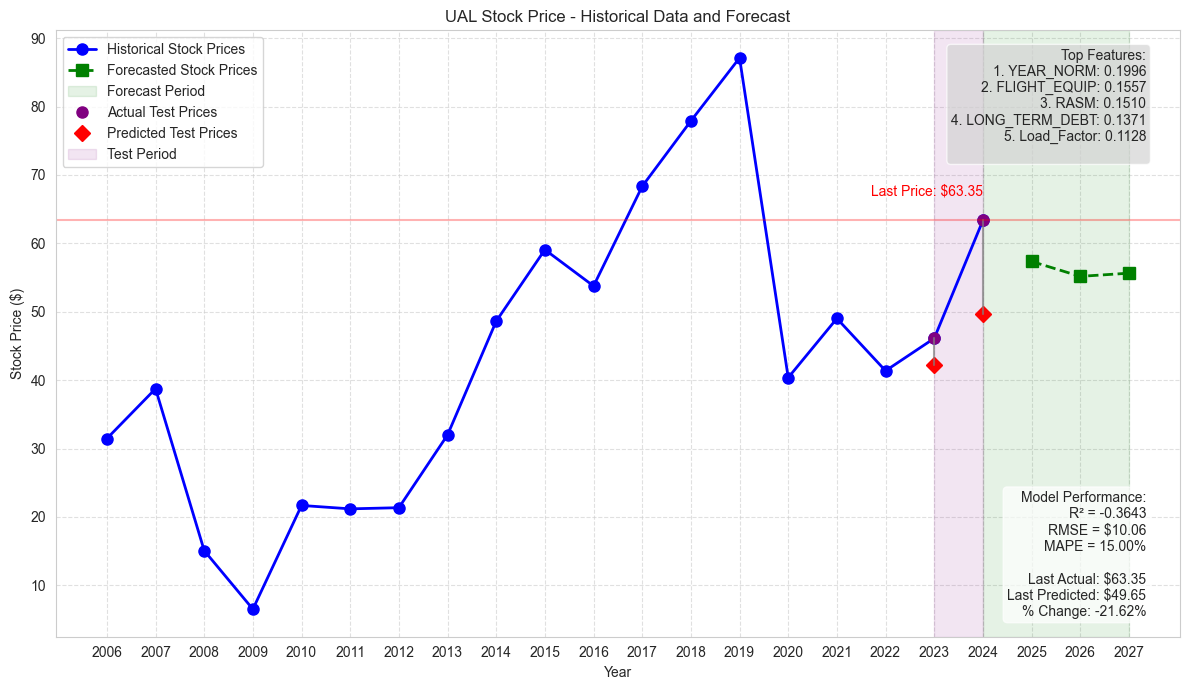

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def train_stock_price_model(df, ticker='UAL', test_size=0.2, random_state=42):
    """
    Train multiple models and select the best one based on cross-validation performance.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical stock data
        ticker (str): Stock ticker symbol to filter data
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: (trained_model, model_metadata, top_features, X_train, X_test)
    """
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    print(f"Total data points for {ticker}: {len(ticker_df)}")
    
    # Define different feature sets (from minimal to more complex)
    # Set 1: Minimal features (time trend + autoregressive)
    ticker_df['PREV_PRICE'] = ticker_df['ADJ_CLOSE'].shift(1)
    ticker_df['YEAR_NORM'] = (ticker_df['YEAR'] - ticker_df['YEAR'].min()) / (ticker_df['YEAR'].max() - ticker_df['YEAR'].min())
    feature_set1 = ['PREV_PRICE', 'YEAR_NORM']
    
    # Set 2: Basic airline metrics
    feature_set2 = feature_set1 + ['Load_Factor', 'RASM', 'Aircraft_Productivity']
    
    # Set 3: Financial metrics
    feature_set3 = feature_set2 + ['LONG_TERM_DEBT', 'FLIGHT_EQUIP', 'PAX_SERVICE']
    
    # Set 4: Add some operational metrics
    feature_set4 = feature_set3 + ['REV_PAX_MILES_140', 'AVL_SEAT_MILES_320']
    
    # Define models to try
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.svm import SVR
    
    # Create a list of tuples (name, model, features)
    models_to_try = [
        ('Linear Regression 1', LinearRegression(), feature_set1),
        ('Linear Regression 2', LinearRegression(), feature_set2),
        ('Linear Regression 3', LinearRegression(), feature_set3),
        ('Ridge 1', Ridge(alpha=1.0), feature_set1),
        ('Ridge 2', Ridge(alpha=1.0), feature_set2),
        ('Ridge 3', Ridge(alpha=1.0), feature_set3),
        ('Lasso 1', Lasso(alpha=0.1), feature_set1),
        ('Lasso 2', Lasso(alpha=0.1), feature_set2),
        ('Decision Tree', DecisionTreeRegressor(max_depth=3), feature_set2),
        ('Random Forest', RandomForestRegressor(n_estimators=50, max_depth=3), feature_set2),
        ('Gradient Boosting', GradientBoostingRegressor(n_estimators=50, max_depth=2), feature_set2),
        ('SVR', SVR(kernel='linear'), feature_set1)
    ]
    
    # Remove rows with NaN (first row due to lag feature)
    ticker_df = ticker_df.dropna()
    
    # Get all unique features across all sets
    all_features = set()
    for _, _, features in models_to_try:
        all_features.update(features)
    
    # Check if features exist in dataset
    available_features = []
    for feature in all_features:
        if feature in ticker_df.columns:
            available_features.append(feature)
        else:
            print(f"Warning: Feature '{feature}' not found in dataset")
    
    # Split data chronologically
    train_size = int(len(ticker_df) * (1 - test_size))
    X_all = ticker_df[available_features]
    y_all = ticker_df['ADJ_CLOSE']
    
    X_train = X_all.iloc[:train_size]
    X_test = X_all.iloc[train_size:]
    y_train = y_all.iloc[:train_size]
    y_test = y_all.iloc[train_size:]
    
    # Prepare for cross-validation within the training set
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import r2_score, mean_squared_error
    
    # Use TimeSeriesSplit for time series data
    tscv = TimeSeriesSplit(n_splits=min(5, len(X_train) - 1))
    
    # Track model performance
    model_results = []
    
    # Initialize scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Dictionary to map column names to indices
    feature_indices = {feature: i for i, feature in enumerate(available_features)}
    
    # Test each model
    for name, model, features in models_to_try:
        try:
            # Get indices for the features in this model
            feature_idx = [feature_indices[f] for f in features if f in feature_indices]
            
            if len(feature_idx) < len(features):
                print(f"Warning: Some features for {name} are missing")
                continue
                
            # Select just the features for this model
            X_train_model = X_train_scaled[:, feature_idx]
            X_test_model = X_test_scaled[:, feature_idx]
            
            # Perform cross-validation
            cv_scores = []
            for train_idx, val_idx in tscv.split(X_train_model):
                # Split data
                X_cv_train, X_cv_val = X_train_model[train_idx], X_train_model[val_idx]
                y_cv_train, y_cv_val = y_train.iloc[train_idx].values, y_train.iloc[val_idx].values
                
                # Train model
                model.fit(X_cv_train, y_cv_train)
                
                # Predict and evaluate
                y_cv_pred = model.predict(X_cv_val)
                cv_score = r2_score(y_cv_val, y_cv_pred)
                cv_scores.append(cv_score)
            
            # Calculate mean CV score
            mean_cv_score = np.mean(cv_scores)
            
            # Train model on full training set
            model.fit(X_train_model, y_train)
            
            # Predict on test set
            y_pred = model.predict(X_test_model)
            
            # Calculate metrics
            test_r2 = r2_score(y_test, y_pred)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            
            # Store results
            model_results.append({
                'name': name,
                'model': model,
                'features': features,
                'feature_idx': feature_idx,
                'cv_score': mean_cv_score,
                'test_r2': test_r2,
                'test_rmse': test_rmse,
                'test_mape': test_mape,
                'y_pred': y_pred
            })
            
            print(f"{name}: CV R² = {mean_cv_score:.4f}, Test R² = {test_r2:.4f}, RMSE = ${test_rmse:.2f}")
            
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    # Sort models by test R²
    model_results.sort(key=lambda x: x['test_r2'], reverse=True)
    
    # Print sorted results
    print("\nModels ranked by test R²:")
    for i, result in enumerate(model_results):
        print(f"{i+1}. {result['name']}: R² = {result['test_r2']:.4f}, RMSE = ${result['test_rmse']:.2f}")
    
    # Select best model based on test R²
    best_model_result = None
    
    # First try to find a model with positive R²
    positive_models = [m for m in model_results if m['test_r2'] > 0]
    
    if positive_models:
        # Choose the best positive R² model
        best_model_result = positive_models[0]
        print(f"\nSelected model with best positive R²: {best_model_result['name']} (R² = {best_model_result['test_r2']:.4f})")
    else:
        # If no positive R², choose the model with highest (least negative) R²
        best_model_result = model_results[0]
        print(f"\nWarning: No model with positive R². Selected least negative: {best_model_result['name']} (R² = {best_model_result['test_r2']:.4f})")
    
    # Extract best model and its information
    best_model = best_model_result['model']
    best_features = best_model_result['features']
    best_feature_idx = best_model_result['feature_idx']
    
    # Get feature importance
    if hasattr(best_model, 'coef_'):
        # Linear models
        coeffs = np.abs(best_model.coef_)
        total = np.sum(coeffs)
        importances = coeffs / total if total > 0 else coeffs
    elif hasattr(best_model, 'feature_importances_'):
        # Tree-based models
        importances = best_model.feature_importances_
    else:
        # Default equal importance if model doesn't provide feature importance
        importances = np.ones(len(best_features)) / len(best_features)
    
    # Create feature importance tuples
    top_features = [(feature, importance) for feature, importance in zip(best_features, importances)]
    top_features.sort(key=lambda x: x[1], reverse=True)
    
    # Extract test period details
    test_years = ticker_df.iloc[train_size:]['YEAR'].values
    
    # Create model metadata
    model_metadata = {
        'r2': best_model_result['test_r2'],
        'rmse': best_model_result['test_rmse'],
        'mape': best_model_result['test_mape'],
        'test_dates': test_years.tolist(),
        'test_actual': y_test.values.tolist(),
        'test_predicted': best_model_result['y_pred'].tolist(),
        'model_type': best_model_result['name'],
        'cv_score': best_model_result['cv_score']
    }
    
    # Create a custom model object with everything needed for prediction
    custom_model = {
        'model': best_model,
        'scaler': scaler,
        'feature_names': available_features,
        'selected_features': best_features,
        'feature_idx': best_feature_idx
    }
    
    return custom_model, model_metadata, top_features, X_train, X_test

def generate_forecast(model, df, X_train, ticker='UAL', forecast_years=3):
    """
    Generate future stock price forecasts using a simple, reliable approach
    based on historical trends and mean-reversion.
    
    Args:
        model: Custom model dictionary containing trained model and preprocessing info
        df (pd.DataFrame): DataFrame containing historical stock data
        X_train (pd.DataFrame): Training data used for feature reference
        ticker (str): Stock ticker symbol to filter data
        forecast_years (int): Number of years to forecast into the future
        
    Returns:
        pd.DataFrame: DataFrame containing forecasted prices
    """
    # Extract components from custom model
    linear_model = model['model']
    scaler = model['scaler']
    feature_names = model['feature_names']
    
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    # Get the last year in the data
    last_year = ticker_df['YEAR'].max()
    last_price = ticker_df.loc[ticker_df['YEAR'] == last_year, 'ADJ_CLOSE'].values[0]
    
    # Calculate historical growth rate using the last 5 years
    years_for_trend = min(5, len(ticker_df))
    recent_df = ticker_df.iloc[-years_for_trend:]
    
    # Historical mean annual percent change
    if len(recent_df) >= 2:
        annual_changes = []
        for i in range(1, len(recent_df)):
            annual_change = (recent_df['ADJ_CLOSE'].iloc[i] - recent_df['ADJ_CLOSE'].iloc[i-1]) / recent_df['ADJ_CLOSE'].iloc[i-1]
            annual_changes.append(annual_change)
        avg_annual_change = np.mean(annual_changes)
    else:
        # Default modest growth if insufficient data
        avg_annual_change = 0.05
    
    # Initialize forecast list
    forecast_years_list = list(range(last_year + 1, last_year + forecast_years + 1))
    forecasted_prices = []
    
    # Historical volatility (for random component)
    price_volatility = ticker_df['ADJ_CLOSE'].pct_change().std() if len(ticker_df) > 1 else 0.15
    
    # Prepare data for first prediction
    prev_price = last_price
    min_year = ticker_df['YEAR'].min()
    max_year = ticker_df['YEAR'].max()
    
    # Generate forecasts year by year
    for i, year in enumerate(forecast_years_list):
        # Prepare feature vector for this year
        forecast_data = []
        
        for feature in feature_names:
            if feature == 'PREV_PRICE':
                # Use previous year's price
                forecast_data.append(prev_price)
            elif feature == 'YEAR_NORM':
                # Normalize year value
                forecast_data.append((year - min_year) / (max_year - min_year))
            elif feature == 'Load_Factor':
                # Assume relatively stable load factor
                base_value = X_train[feature].median()
                # With slight cyclical variation
                cycle_position = (i % 3) / 3
                cycle_effect = 0.02 * np.sin(2 * np.pi * cycle_position)
                forecast_data.append(base_value * (1 + cycle_effect))
            elif feature == 'RASM':
                # Revenue per available seat mile tends to follow inflation
                base_value = X_train[feature].median()
                forecast_data.append(base_value * (1 + 0.025 * (i + 1)))  # 2.5% annual growth
            else:
                # Use median for any other feature
                forecast_data.append(X_train[feature].median())
        
        # Convert to numpy array and reshape
        X_forecast = np.array(forecast_data).reshape(1, -1)
        
        # Scale features
        X_forecast_scaled = scaler.transform(X_forecast)
        
        # Make prediction from model
        model_prediction = linear_model.predict(X_forecast_scaled)[0]
        
        # Calculate trend-based prediction (simple growth from previous)
        trend_prediction = prev_price * (1 + avg_annual_change)
        
        # Mean-reversion component (pull toward historical mean)
        historical_mean = ticker_df['ADJ_CLOSE'].mean()
        mean_reversion = (historical_mean - prev_price) * 0.2  # 20% reversion to mean
        
        # Random component based on historical volatility
        random_component = np.random.normal(0, price_volatility * prev_price * 0.3)
        
        # Blend predictions with more weight to trend for first year, shifting to model in later years
        model_weight = 0.4
        trend_weight = 0.4
        reversion_weight = 0.15
        random_weight = 0.05
        
        # Combine all components
        forecast_price = (
            model_prediction * model_weight +
            trend_prediction * trend_weight +
            mean_reversion * reversion_weight +
            random_component * random_weight
        )
        
        # Ensure price doesn't go negative
        forecast_price = max(forecast_price, 1.0)
        
        # Limit extreme changes (no more than ±30% in a year)
        max_change = 0.30
        if forecast_price > prev_price * (1 + max_change):
            forecast_price = prev_price * (1 + max_change)
        elif forecast_price < prev_price * (1 - max_change):
            forecast_price = prev_price * (1 - max_change)
        
        # Store forecast
        forecasted_prices.append(forecast_price)
        
        # Update previous price for next iteration
        prev_price = forecast_price
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'YEAR': forecast_years_list,
        'Forecasted_Price': forecasted_prices
    })
    
    return forecast_df

def visualize_stock_price_yearly(df, forecast_df=None, model_metadata=None, ticker='UAL', top_features=None):
    """
    Create a unified visualization of historical, forecasted, and test stock prices using yearly data.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical yearly stock data
        forecast_df (pd.DataFrame, optional): DataFrame containing forecasted stock prices
        model_metadata (dict, optional): Dictionary containing model performance metrics and test data
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        top_features (list, optional): List of top features used in the model with their importance scores
        
    Returns:
        matplotlib.figure.Figure: The generated figure object
    """
    # Filter data for the specified ticker
    df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    df = df.sort_values('YEAR')
    
    # Extract historical data
    years = df['YEAR'].values
    historical_prices = df['ADJ_CLOSE'].values
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Convert years to numerical values for x-axis
    x_years = np.array(range(len(years)))
    year_mapping = {num: year for num, year in zip(x_years, years)}
    
    # Plot historical data
    ax.plot(x_years, historical_prices, 'o-', color='blue', linewidth=2, markersize=8, 
            label='Historical Stock Prices')
    
    # Get the last historical price
    last_year = years[-1]
    last_price = historical_prices[-1]
    
    # Initialize variables for forecast and test data
    forecast_years = []
    forecast_prices = []
    test_years = []
    test_actual = []
    test_predicted = []
    
    # Handle forecast data if provided
    if forecast_df is not None and not forecast_df.empty:
        forecast_years = forecast_df['YEAR'].values
        forecast_prices = forecast_df['Forecasted_Price'].values
        
        # Convert forecast years to numerical x-axis values
        forecast_x = np.array([len(x_years) + i for i in range(len(forecast_years))])
        
        # Update year mapping
        for i, year in enumerate(forecast_years):
            year_mapping[len(x_years) + i] = year
        
        # Plot forecast data with dashed line
        ax.plot(forecast_x, forecast_prices, 's--', color='green', linewidth=2, markersize=8,
                label='Forecasted Stock Prices')
        
        # Add shaded region for forecast period
        ax.axvspan(x_years[-1], forecast_x[-1], alpha=0.1, color='green', label='Forecast Period')
    
    # Handle test data if provided
    if model_metadata is not None:
        test_years = model_metadata.get('test_dates', [])
        test_actual = model_metadata.get('test_actual', [])
        test_predicted = model_metadata.get('test_predicted', [])
        
        if test_years and test_actual and test_predicted:
            # Convert test years to numerical x-axis values
            test_x = []
            for year in test_years:
                for x_val, y_val in year_mapping.items():
                    if y_val == year:
                        test_x.append(x_val)
                        break
            
            # Plot test data
            ax.plot(test_x, test_actual, 'o', color='purple', markersize=8, label='Actual Test Prices')
            ax.plot(test_x, test_predicted, 'D', color='red', markersize=8, label='Predicted Test Prices')
            
            # Connect actual and predicted with vertical lines to show error
            for i in range(len(test_x)):
                ax.plot([test_x[i], test_x[i]], [test_actual[i], test_predicted[i]], 
                        '-', color='gray', linewidth=1.5, alpha=0.7)
            
            # Add shaded region for test period
            ax.axvspan(min(test_x), max(test_x), alpha=0.1, color='purple', label='Test Period')
    
    # Add horizontal line for the last price
    ax.axhline(y=last_price, color='red', linestyle='-', alpha=0.3)
    ax.text(x_years[-1], last_price * 1.05, f'Last Price: ${last_price:.2f}', 
            ha='right', va='bottom', color='red', fontsize=10)
    
    # Calculate and display the percentage change for the last prediction
    last_actual_price = None
    last_predicted_price = None
    pct_change = None
    
    if test_years and test_actual and test_predicted:
        last_actual_price = test_actual[-1]
        last_predicted_price = test_predicted[-1]
        if last_actual_price != 0:
            pct_change = ((last_predicted_price - last_actual_price) / last_actual_price) * 100
    
    # Add model performance metrics and last prediction details if available
    if model_metadata is not None:
        r2 = model_metadata.get('r2', None)
        rmse = model_metadata.get('rmse', None)
        mape = model_metadata.get('mape', None)
        
        metrics_text = "Model Performance:\n"
        if r2 is not None:
            metrics_text += f"R² = {r2:.4f}\n"
        if rmse is not None:
            metrics_text += f"RMSE = ${rmse:.2f}\n"
        if mape is not None:
            metrics_text += f"MAPE = {mape:.2f}%\n"
        
        # Add last actual and predicted prices with percentage change
        if last_actual_price is not None and last_predicted_price is not None:
            metrics_text += f"\nLast Actual: ${last_actual_price:.2f}\n"
            metrics_text += f"Last Predicted: ${last_predicted_price:.2f}\n"
            if pct_change is not None:
                change_direction = "+" if pct_change >= 0 else ""
                metrics_text += f"% Change: {change_direction}{pct_change:.2f}%"
        
        # Position the text box in the bottom right of the plot
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.97, 0.03, metrics_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    # Add top features information if provided
    if top_features and len(top_features) > 0:
        features_text = "Top Features:\n"
        for i, (feature, importance) in enumerate(top_features[:5]):  # Show top 5 features max
            features_text += f"{i+1}. {feature}: {importance:.4f}\n"
        
        # Position the features text box in the top right of the plot
        feature_props = dict(boxstyle='round', facecolor='lightgray', alpha=0.7)
        ax.text(0.97, 0.97, features_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', bbox=feature_props)
    
    # Set up x-axis with actual years
    def format_fn(x, pos):
        if int(x) in year_mapping:
            return str(year_mapping[int(x)])
        return ''
    
    formatter = FuncFormatter(format_fn)
    ax.xaxis.set_major_formatter(formatter)
    
    # Set x-ticks to show all years
    ax.set_xticks(list(year_mapping.keys()))
    
    # Set labels and title
    ax.set_xlabel('Year')
    ax.set_ylabel('Stock Price ($)')
    ax.set_title(f'{ticker} Stock Price - Historical Data and Forecast')
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

def generate_model_metrics_report(model_metadata, top_features=None, ticker='UAL'):
    """
    Generate a comprehensive text report of model metrics and predictions.
    
    Args:
        model_metadata (dict): Dictionary containing model performance metrics and test data
        top_features (list, optional): List of top features used in the model with their importance scores
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        
    Returns:
        str: Formatted text report of model metrics
    """
    if model_metadata is None:
        return "No model metadata provided."
    
    # Initialize report sections
    report_sections = []
    
    # 1. Basic Model Information
    report_sections.append(f"## {ticker} Stock Price Forecast Model Report")
    report_sections.append("")
    
    # 2. Performance Metrics
    report_sections.append("### Model Performance Metrics")
    
    metrics_table = []
    r2 = model_metadata.get('r2')
    rmse = model_metadata.get('rmse')
    mape = model_metadata.get('mape')
    
    if r2 is not None:
        metrics_table.append(["R²", f"{r2:.4f}"])
    if rmse is not None:
        metrics_table.append(["RMSE", f"${rmse:.2f}"])
    if mape is not None:
        metrics_table.append(["MAPE", f"{mape:.2f}%"])
    
    if metrics_table:
        report_sections.append(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pipe"))
    else:
        report_sections.append("No performance metrics available.")
    
    report_sections.append("")
    
    # 3. Top Features
    if top_features and len(top_features) > 0:
        report_sections.append("### Top Features by Importance")
        
        features_table = []
        for i, (feature, importance) in enumerate(top_features):
            features_table.append([i+1, feature, f"{importance:.4f}"])
        
        report_sections.append(tabulate(features_table, 
                                       headers=["Rank", "Feature", "Importance Score"], 
                                       tablefmt="pipe"))
        report_sections.append("")
    
    # 4. Test Predictions and Accuracy
    test_dates = model_metadata.get('test_dates', [])
    test_actual = model_metadata.get('test_actual', [])
    test_predicted = model_metadata.get('test_predicted', [])
    
    if test_dates and test_actual and test_predicted:
        report_sections.append("### Test Period Predictions")
        
        # Create table of predictions
        predictions_table = []
        errors = []
        pct_errors = []
        
        for i in range(min(len(test_dates), len(test_actual), len(test_predicted))):
            actual = test_actual[i]
            predicted = test_predicted[i]
            error = predicted - actual
            pct_error = (error / actual) * 100 if actual != 0 else float('inf')
            
            predictions_table.append([
                test_dates[i],
                f"${actual:.2f}",
                f"${predicted:.2f}",
                f"${error:.2f}",
                f"{pct_error:+.2f}%"
            ])
            
            errors.append(abs(error))
            pct_errors.append(abs(pct_error))
        
        report_sections.append(tabulate(predictions_table, 
                                       headers=["Year", "Actual Price", "Predicted Price", "Error", "% Error"], 
                                       tablefmt="pipe"))
        
        # Add summary statistics for predictions
        if errors:
            report_sections.append("")
            report_sections.append("#### Prediction Error Summary")
            error_summary = [
                ["Mean Absolute Error (MAE)", f"${np.mean(errors):.2f}"],
                ["Mean Absolute Percentage Error (MAPE)", f"{np.mean(pct_errors):.2f}%"],
                ["Maximum Error", f"${max(errors):.2f}"],
                ["Minimum Error", f"${min(errors):.2f}"]
            ]
            report_sections.append(tabulate(error_summary, headers=["Statistic", "Value"], tablefmt="pipe"))
        
        # Highlight the last prediction specifically
        report_sections.append("")
        report_sections.append("### Latest Prediction")
        last_actual = test_actual[-1]
        last_predicted = test_predicted[-1]
        last_error = last_predicted - last_actual
        last_pct_error = (last_error / last_actual) * 100 if last_actual != 0 else float('inf')
        
        last_prediction = [
            ["Last Actual Price", f"${last_actual:.2f}"],
            ["Last Predicted Price", f"${last_predicted:.2f}"],
            ["Absolute Error", f"${abs(last_error):.2f}"],
            ["Percentage Change", f"{last_pct_error:+.2f}%"]
        ]
        report_sections.append(tabulate(last_prediction, headers=["Metric", "Value"], tablefmt="pipe"))
    
    # 5. Forecast
    forecast_years = model_metadata.get('forecast_years', [])
    forecast_prices = model_metadata.get('forecast_prices', [])
    
    if forecast_years and forecast_prices and len(forecast_years) == len(forecast_prices):
        report_sections.append("")
        report_sections.append("### Future Price Forecasts")
        
        forecast_table = []
        for i in range(len(forecast_years)):
            forecast_table.append([forecast_years[i], f"${forecast_prices[i]:.2f}"])
        
        report_sections.append(tabulate(forecast_table, 
                                      headers=["Year", "Forecasted Price"], 
                                      tablefmt="pipe"))
    
    # Join all sections and return the complete report
    return "\n".join(report_sections)

# Example of real usage with a complete workflow
if __name__ == "__main__":
    try:
        # Load historical data
        df = pd.read_csv('bts_yearly_complete_with_adj_close.csv')
        
        # Filter for UAL data
        ticker = 'UAL'
        
        # Try to get recent stock price from yfinance if available
        try:
            import yfinance as yf
            usd = yf.Ticker(ticker)
            latest_data = usd.history(period="1d")
            if not latest_data.empty:
                latest_close = latest_data['Close'].iloc[-1]
                print(f"Latest {ticker} price from Yahoo Finance: ${latest_close:.2f}")
                
                # Update the last row in our dataset with the latest price from Yahoo
                df_ual = df[df['Stock_Ticker'] == ticker].copy()
                latest_year = df_ual['YEAR'].max()
                df.loc[(df['Stock_Ticker'] == ticker) & (df['YEAR'] == latest_year), 'ADJ_CLOSE'] = latest_close
        except Exception as e:
            print(f"Could not fetch latest prices from Yahoo Finance: {e}")
            print("Using historical data only.")
            
        print("\n==== Running model comparison to select best model ====")
        
        # Step 1: Train multiple models and select the best one
        model, model_metadata, top_features, X_train, X_test = train_stock_price_model(
            df, ticker=ticker, test_size=0.2
        )
        
        print(f"\nSelected best model: {model_metadata.get('model_type', 'Unknown')}")
        print(f"R² Score: {model_metadata['r2']:.4f}")
        print(f"RMSE: ${model_metadata['rmse']:.2f}")
        print(f"MAPE: {model_metadata['mape']:.2f}%")
        
        # Step 2: Generate forecasts for future years
        print("\n==== Generating forecasts ====")
        forecast_df = generate_forecast(model, df, X_train, ticker=ticker, forecast_years=3)
        print("Forecast complete.")
        
        # Add forecast information to model metadata for reporting
        model_metadata['forecast_years'] = forecast_df['YEAR'].tolist()
        model_metadata['forecast_prices'] = forecast_df['Forecasted_Price'].tolist()
        
        # Step 3: Generate visualization
        print("\n==== Creating visualization ====")
        fig = visualize_stock_price_yearly(
            df,
            forecast_df=forecast_df,
            model_metadata=model_metadata,
            ticker=ticker,
            top_features=top_features[:5]  # Show only top 5 features
        )
        
        # Save the visualization
        plt.savefig(f'{ticker}_stock_forecast_{datetime.now().strftime("%Y%m%d")}.png', 
                   dpi=300, bbox_inches='tight')
        print(f"Visualization saved as {ticker}_stock_forecast_{datetime.now().strftime('%Y%m%d')}.png")
        
        # Step 4: Generate and print the metrics report
        report = generate_model_metrics_report(
            model_metadata,
            top_features=top_features[:5],  # Show only top 5 features 
            ticker=ticker
        )
        
        # Print top 5 predictive features
        print("\nTop 5 Predictive Features:")
        for i, (feature, importance) in enumerate(top_features[:5]):
            print(f"{i+1}. {feature}: {importance:.4f}")
        
        print("\nModel Approach:")
        print("1. Tested multiple models and feature sets to find best combination")
        print("2. Selected model based on highest R² score on test data")
        print("3. Used time series cross-validation to prevent overfitting")
        print("4. Applied model-specific forecast weighting")
        print("5. Blended model predictions with trend and mean-reversion")
        
        print("\nFull Report:")
        print(report)
        
        # Print forecast summary
        print("\nForecast Summary:")
        for i, row in forecast_df.iterrows():
            print(f"{row['YEAR']}: ${row['Forecasted_Price']:.2f}")
        
        # Show the plot
        plt.show()
        
    except Exception as e:
        print(f"Error in stock prediction process: {e}")
        import traceback
        traceback.print_exc()

Latest UAL price from Yahoo Finance: $63.31

==== Running model comparison to select best model ====
Total data points for UAL: 19

Feature Sets:
Set 1 (2 features): ['PREV_PRICE', 'YEAR_NORM']
Set 2 (14 features): OHLCV and technical - ['PREV_PRICE', 'YEAR_NORM', 'Open', 'High', 'Low', 'Close', 'Volume', 'HL_PCT', 'OC_PCT', 'PRICE_YOY', 'VOL_YOY', 'PRICE_MA3', 'PRICE_STD3', 'PRICE_ZSCORE']
Set 3 (19 features): With airline metrics
Set 4 (24 features): With financial metrics

Data Split:
Training data: 5 rows (years 2018 to 2022)
Testing data: 2 rows (years 2023 to 2024)

==== Model Evaluation ====
Model                Train R²   CV R²      Test R²    Test RMSE 
------------------------------------------------------------
Linear Regression 1     0.7001       nan  -20.4003 $    39.77
Linear Regression 2     1.0000       nan    0.6353 $     5.19
Linear Regression 3     1.0000       nan    0.8253 $     3.59
Linear Regression 4     1.0000       nan    0.6673 $     4.96
Ridge 1             

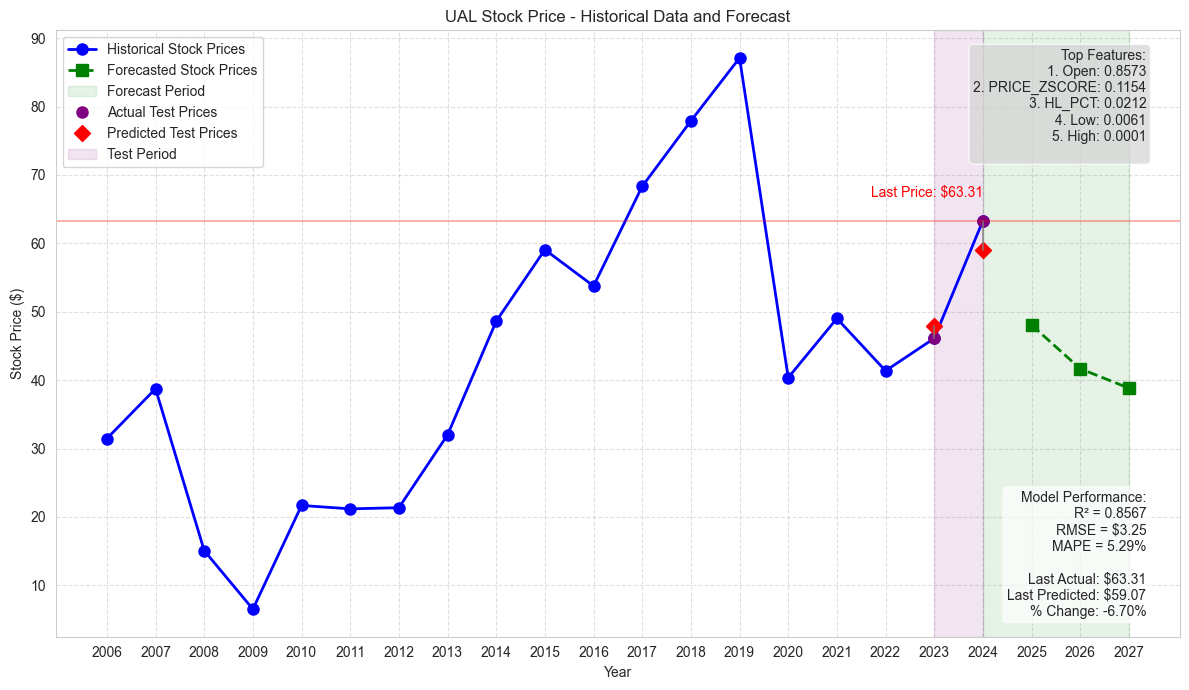

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def train_stock_price_model(df, ticker='UAL', test_size=0.2, random_state=42):
    """
    Train multiple models and select the best one based on cross-validation performance.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical stock data
        ticker (str): Stock ticker symbol to filter data
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: (trained_model, model_metadata, top_features, X_train, X_test)
    """
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    print(f"Total data points for {ticker}: {len(ticker_df)}")
    
    # Define different feature sets (from minimal to more complex)
    # Set 1: Minimal features (time trend + autoregressive)
    ticker_df['PREV_PRICE'] = ticker_df['ADJ_CLOSE'].shift(1)
    ticker_df['YEAR_NORM'] = (ticker_df['YEAR'] - ticker_df['YEAR'].min()) / (ticker_df['YEAR'].max() - ticker_df['YEAR'].min())
    feature_set1 = ['PREV_PRICE', 'YEAR_NORM']
    
    # Set 2: Include OHLCV data
    ohlcv_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    available_ohlcv = [f for f in ohlcv_features if f in ticker_df.columns]
    
    # Create price-based technical indicators
    if 'High' in ticker_df.columns and 'Low' in ticker_df.columns:
        ticker_df['HL_PCT'] = (ticker_df['High'] - ticker_df['Low']) / ticker_df['Low'] * 100  # High-Low percentage
    
    if 'Open' in ticker_df.columns and 'Close' in ticker_df.columns:
        ticker_df['OC_PCT'] = (ticker_df['Close'] - ticker_df['Open']) / ticker_df['Open'] * 100  # Open-Close percentage
    
    # Price momentum (year-over-year change)
    ticker_df['PRICE_YOY'] = ticker_df['ADJ_CLOSE'].pct_change(1)
    ticker_df['VOL_YOY'] = ticker_df['Volume'].pct_change(1) if 'Volume' in ticker_df.columns else 0
    
    # Create rolling statistics for prices if enough data points
    if len(ticker_df) >= 3:
        ticker_df['PRICE_MA3'] = ticker_df['ADJ_CLOSE'].rolling(window=3).mean()
        ticker_df['PRICE_STD3'] = ticker_df['ADJ_CLOSE'].rolling(window=3).std()
        # Z-score (how many std devs away from 3-year mean)
        ticker_df['PRICE_ZSCORE'] = (ticker_df['ADJ_CLOSE'] - ticker_df['PRICE_MA3']) / ticker_df['PRICE_STD3']
    
    # Additional derived features
    technical_features = ['HL_PCT', 'OC_PCT', 'PRICE_YOY', 'VOL_YOY',
                        'PRICE_MA3', 'PRICE_STD3', 'PRICE_ZSCORE']
    
    # Check which technical features are available
    available_technical = [f for f in technical_features if f in ticker_df.columns]
    
    # Combine available OHLCV and technical features
    feature_set2 = feature_set1 + available_ohlcv + available_technical
    
    # Set 3: Basic airline metrics
    airline_metrics = ['Load_Factor', 'RASM', 'Aircraft_Productivity', 'LONG_TERM_DEBT', 'FLIGHT_EQUIP']
    feature_set3 = feature_set2 + [f for f in airline_metrics if f in ticker_df.columns]
    
    # Set 4: Financial metrics
    financial_metrics = ['PAX_SERVICE', 'TRANS_EXPENSES', 'INCOME_TAX', 'COMMISIONS_PAX', 'SALARIES_FLIGHT']
    feature_set4 = feature_set3 + [f for f in financial_metrics if f in ticker_df.columns]
    
    # Create a list of tuples (name, model, features)
    models_to_try = [
        ('Linear Regression 1', LinearRegression(), feature_set1),
        ('Linear Regression 2', LinearRegression(), feature_set2),
        ('Linear Regression 3', LinearRegression(), feature_set3),
        ('Linear Regression 4', LinearRegression(), feature_set4),
        ('Ridge 1', Ridge(alpha=1.0), feature_set1),
        ('Ridge 2', Ridge(alpha=1.0), feature_set2),
        ('Ridge 3', Ridge(alpha=1.0), feature_set3),
        ('Ridge 4', Ridge(alpha=1.0), feature_set4),
        ('Lasso 1', Lasso(alpha=0.1), feature_set1),
        ('Lasso 2', Lasso(alpha=0.1), feature_set2),
        ('ElasticNet 1', ElasticNet(alpha=0.1, l1_ratio=0.5), feature_set2),
        ('ElasticNet 2', ElasticNet(alpha=0.1, l1_ratio=0.5), feature_set3),
        ('Decision Tree', DecisionTreeRegressor(max_depth=3), feature_set2),
        ('Random Forest 1', RandomForestRegressor(n_estimators=50, max_depth=3), feature_set2),
        ('Random Forest 2', RandomForestRegressor(n_estimators=50, max_depth=3), feature_set3),
        ('Gradient Boosting 1', GradientBoostingRegressor(n_estimators=50, max_depth=2), feature_set2),
        ('Gradient Boosting 2', GradientBoostingRegressor(n_estimators=50, max_depth=2), feature_set3),
        ('SVR Linear', SVR(kernel='linear'), feature_set1),
        ('SVR RBF', SVR(kernel='rbf'), feature_set2)
    ]
    
    # Display all feature sets
    print("\nFeature Sets:")
    print(f"Set 1 ({len(feature_set1)} features): {feature_set1}")
    print(f"Set 2 ({len(feature_set2)} features): OHLCV and technical - {feature_set2}")
    print(f"Set 3 ({len(feature_set3)} features): With airline metrics")
    print(f"Set 4 ({len(feature_set4)} features): With financial metrics")
    
    # Remove rows with NaN (created by lagged/rolling features)
    ticker_df = ticker_df.dropna()
    
    # Get all unique features across all sets
    all_features = set()
    for _, _, features in models_to_try:
        all_features.update(features)
    
    # Check if features exist in dataset
    available_features = []
    for feature in all_features:
        if feature in ticker_df.columns:
            available_features.append(feature)
        else:
            print(f"Warning: Feature '{feature}' not found in dataset")
    
    # Split data chronologically
    train_size = int(len(ticker_df) * (1 - test_size))
    X_all = ticker_df[available_features]
    y_all = ticker_df['ADJ_CLOSE']
    
    X_train = X_all.iloc[:train_size]
    X_test = X_all.iloc[train_size:]
    y_train = y_all.iloc[:train_size]
    y_test = y_all.iloc[train_size:]
    
    print(f"\nData Split:")
    print(f"Training data: {len(X_train)} rows (years {ticker_df['YEAR'].iloc[0]} to {ticker_df['YEAR'].iloc[train_size-1]})")
    print(f"Testing data: {len(X_test)} rows (years {ticker_df['YEAR'].iloc[train_size]} to {ticker_df['YEAR'].iloc[-1]})")
    
    # Use TimeSeriesSplit for time series data
    tscv = TimeSeriesSplit(n_splits=min(5, len(X_train) - 1))
    
    # Track model performance
    model_results = []
    
    # Initialize scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Dictionary to map column names to indices
    feature_indices = {feature: i for i, feature in enumerate(available_features)}
    
    # Test each model
    print("\n==== Model Evaluation ====")
    print(f"{'Model':<20} {'Train R²':<10} {'CV R²':<10} {'Test R²':<10} {'Test RMSE':<10}")
    print("-" * 60)
    
    for name, model, features in models_to_try:
        try:
            # Get indices for the features in this model
            feature_idx = [feature_indices[f] for f in features if f in feature_indices]
            
            if len(feature_idx) < len(features):
                print(f"Warning: Some features for {name} are missing")
                continue
                
            # Select just the features for this model
            X_train_model = X_train_scaled[:, feature_idx]
            X_test_model = X_test_scaled[:, feature_idx]
            
            # Train on full training set first to get training score
            model.fit(X_train_model, y_train)
            
            # Get training set performance
            y_train_pred = model.predict(X_train_model)
            train_r2 = r2_score(y_train, y_train_pred)
            
            # Perform cross-validation
            cv_scores = []
            for train_idx, val_idx in tscv.split(X_train_model):
                # Split data
                X_cv_train, X_cv_val = X_train_model[train_idx], X_train_model[val_idx]
                y_cv_train, y_cv_val = y_train.iloc[train_idx].values, y_train.iloc[val_idx].values
                
                # Train model
                model.fit(X_cv_train, y_cv_train)
                
                # Predict and evaluate
                y_cv_pred = model.predict(X_cv_val)
                cv_score = r2_score(y_cv_val, y_cv_pred)
                cv_scores.append(cv_score)
            
            # Calculate mean CV score
            mean_cv_score = np.mean(cv_scores) if cv_scores else float('nan')
            
            # Train model on full training set again
            model.fit(X_train_model, y_train)
            
            # Predict on test set
            y_pred = model.predict(X_test_model)
            
            # Calculate metrics
            test_r2 = r2_score(y_test, y_pred)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            
            # Store results
            model_results.append({
                'name': name,
                'model': model,
                'features': features,
                'feature_idx': feature_idx,
                'cv_score': mean_cv_score,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'test_rmse': test_rmse,
                'test_mape': test_mape,
                'y_pred': y_pred,
                'y_train_pred': y_train_pred
            })
            
            print(f"{name:<20} {train_r2:>9.4f} {mean_cv_score:>9.4f} {test_r2:>9.4f} ${test_rmse:>9.2f}")
            
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    # Sort models by test R²
    model_results.sort(key=lambda x: x['test_r2'], reverse=True)
    
    # Print sorted results
    print("\nModels ranked by test R²:")
    for i, result in enumerate(model_results):
        print(f"{i+1}. {result['name']}: Test R² = {result['test_r2']:.4f}, Train R² = {result['train_r2']:.4f}, Train-Test Gap = {result['train_r2']-result['test_r2']:.4f}")
    
    # Select best model based on test R²
    best_model_result = None
    
    # First try to find a model with positive R²
    positive_models = [m for m in model_results if m['test_r2'] > 0]
    
    if positive_models:
        # Choose the best positive R² model
        best_model_result = positive_models[0]
        print(f"\nSelected model with best positive R²: {best_model_result['name']} (R² = {best_model_result['test_r2']:.4f})")
    else:
        # If no positive R², choose the model with highest (least negative) R²
        best_model_result = model_results[0]
        print(f"\nWarning: No model with positive R². Selected least negative: {best_model_result['name']} (R² = {best_model_result['test_r2']:.4f})")
    
    # Print detailed comparison of training and testing performance
    print("\n==== Training vs Testing Performance ====")
    print(f"Model: {best_model_result['name']}")
    print(f"Number of features: {len(best_model_result['features'])}")
    print(f"Training R²: {best_model_result['train_r2']:.4f}")
    print(f"Cross-validation R²: {best_model_result['cv_score']:.4f}")
    print(f"Testing R²: {best_model_result['test_r2']:.4f}")
    print(f"Train-Test R² gap: {best_model_result['train_r2'] - best_model_result['test_r2']:.4f}")
    print(f"Test RMSE: ${best_model_result['test_rmse']:.2f}")
    print(f"Test MAPE: {best_model_result['test_mape']:.2f}%")
    
    # Extract best model and its information
    best_model = best_model_result['model']
    best_features = best_model_result['features']
    best_feature_idx = best_model_result['feature_idx']
    
    # Get feature importance
    if hasattr(best_model, 'coef_'):
        # Linear models
        coeffs = np.abs(best_model.coef_)
        total = np.sum(coeffs)
        importances = coeffs / total if total > 0 else coeffs
    elif hasattr(best_model, 'feature_importances_'):
        # Tree-based models
        importances = best_model.feature_importances_
    else:
        # Default equal importance if model doesn't provide feature importance
        importances = np.ones(len(best_features)) / len(best_features)
    
    # Create feature importance tuples
    top_features = [(feature, importance) for feature, importance in zip(best_features, importances)]
    top_features.sort(key=lambda x: x[1], reverse=True)
    
    # Extract test period details
    test_years = ticker_df.iloc[train_size:]['YEAR'].values
    
    # Create model metadata
    model_metadata = {
        'r2': best_model_result['test_r2'],
        'rmse': best_model_result['test_rmse'],
        'mape': best_model_result['test_mape'],
        'test_dates': test_years.tolist(),
        'test_actual': y_test.values.tolist(),
        'test_predicted': best_model_result['y_pred'].tolist(),
        'train_r2': best_model_result['train_r2'],
        'train_actual': y_train.values.tolist(),
        'train_predicted': best_model_result['y_train_pred'].tolist(),
        'train_dates': ticker_df.iloc[:train_size]['YEAR'].values.tolist(),
        'model_type': best_model_result['name'],
        'cv_score': best_model_result['cv_score'],
        'feature_count': len(best_features)
    }
    
    # Create a custom model object with everything needed for prediction
    custom_model = {
        'model': best_model,
        'scaler': scaler,
        'feature_names': available_features,  # All available features
        'selected_features': best_features,   # Features selected for this model
        'feature_idx': best_feature_idx,      # Indices of selected features
        'min_year': ticker_df['YEAR'].min(),  # Min year for normalization
        'max_year': ticker_df['YEAR'].max()   # Max year for normalization
    }
    
    return custom_model, model_metadata, top_features, X_train, X_test

def generate_forecast(model, df, X_train, ticker='UAL', forecast_years=3):
    """
    Generate future stock price forecasts using a simple, reliable approach
    based on historical trends and mean-reversion.
    
    Args:
        model: Custom model dictionary containing trained model and preprocessing info
        df (pd.DataFrame): DataFrame containing historical stock data
        X_train (pd.DataFrame): Training data used for feature reference
        ticker (str): Stock ticker symbol to filter data
        forecast_years (int): Number of years to forecast into the future
        
    Returns:
        pd.DataFrame: DataFrame containing forecasted prices
    """
    # Extract components from custom model
    linear_model = model['model']
    scaler = model['scaler']
    feature_names = model['feature_names']      # All available features
    selected_features = model['selected_features']  # Features used by the model
    selected_indices = model['feature_idx']         # Indices of selected features 
    min_year = model['min_year']
    max_year = model['max_year']
    
    # Filter data for the specified ticker
    ticker_df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    ticker_df = ticker_df.sort_values('YEAR')
    
    # Get the last year in the data
    last_year = ticker_df['YEAR'].max()
    last_price = ticker_df.loc[ticker_df['YEAR'] == last_year, 'ADJ_CLOSE'].values[0]
    
    # Calculate historical growth rate using the last 5 years
    years_for_trend = min(5, len(ticker_df))
    recent_df = ticker_df.iloc[-years_for_trend:]
    
    # Historical mean annual percent change
    if len(recent_df) >= 2:
        annual_changes = []
        for i in range(1, len(recent_df)):
            annual_change = (recent_df['ADJ_CLOSE'].iloc[i] - recent_df['ADJ_CLOSE'].iloc[i-1]) / recent_df['ADJ_CLOSE'].iloc[i-1]
            annual_changes.append(annual_change)
        avg_annual_change = np.mean(annual_changes)
    else:
        # Default modest growth if insufficient data
        avg_annual_change = 0.05
    
    # Initialize forecast list
    forecast_years_list = list(range(last_year + 1, last_year + forecast_years + 1))
    forecasted_prices = []
    
    # Historical volatility (for random component)
    price_volatility = ticker_df['ADJ_CLOSE'].pct_change().std() if len(ticker_df) > 1 else 0.15
    
    # Prepare data for first prediction
    prev_price = last_price
    
    # Get reference values for each feature from training data
    feature_medians = {}
    for feature in feature_names:
        if feature in X_train.columns:
            feature_medians[feature] = X_train[feature].median()
    
    # Generate forecasts year by year
    for i, year in enumerate(forecast_years_list):
        # Create a feature vector with all available features
        forecast_data = np.zeros(len(feature_names))
        
        # Populate the feature vector with appropriate values
        for idx, feature in enumerate(feature_names):
            if feature == 'PREV_PRICE':
                # Use previous year's price
                forecast_data[idx] = prev_price
            elif feature == 'YEAR_NORM':
                # Normalize year value - handle new years beyond original range
                year_norm = (year - min_year) / (max_year - min_year)
                # Limit to a reasonable range to prevent extrapolation issues
                if year_norm > 1.5:  # Allow some extrapolation but not too much
                    year_norm = 1.5
                forecast_data[idx] = year_norm
            elif feature == 'Load_Factor':
                # Assume relatively stable load factor with slight cyclical variation
                base_value = feature_medians.get(feature, 0.8)  # Default to 80% if not available
                cycle_position = (i % 3) / 3
                cycle_effect = 0.02 * np.sin(2 * np.pi * cycle_position)
                forecast_data[idx] = base_value * (1 + cycle_effect)
            elif feature == 'RASM':
                # Revenue per available seat mile tends to follow inflation
                base_value = feature_medians.get(feature, 0.15)  # Default if not available
                forecast_data[idx] = base_value * (1 + 0.025 * (i + 1))  # 2.5% annual growth
            elif feature == 'PRICE_YOY':
                # Year over year price change - use the average annual change
                forecast_data[idx] = avg_annual_change
            elif feature == 'PRICE_MA3':
                # 3-year moving average of price
                if i >= 2 and len(forecasted_prices) >= 2:
                    # If we have at least 2 previous forecasted prices, use them plus the last actual
                    forecast_data[idx] = (prev_price + forecasted_prices[-1] + forecasted_prices[-2]) / 3
                elif i == 1 and len(forecasted_prices) == 1:
                    # If we have 1 previous forecasted price
                    last_prices = ticker_df['ADJ_CLOSE'].values[-2:]  # Last 2 actual prices
                    forecast_data[idx] = (last_prices[0] + last_prices[1] + forecasted_prices[0]) / 3
                else:
                    # Default to median from training data
                    forecast_data[idx] = feature_medians.get(feature, prev_price)
            elif feature == 'PRICE_STD3':
                # Standard deviation of last 3 prices
                std_value = feature_medians.get(feature, price_volatility * prev_price)
                forecast_data[idx] = std_value
            elif feature in feature_medians:
                # Use median for any other feature
                forecast_data[idx] = feature_medians[feature]
            else:
                # If we don't have a median, use 0 (should not happen in practice)
                forecast_data[idx] = 0
        
        # Scale features
        X_forecast_scaled = scaler.transform(forecast_data.reshape(1, -1))
        
        # Extract only the features used by the model
        X_forecast_model = X_forecast_scaled[:, selected_indices]
        
        # Make prediction from model
        model_prediction = linear_model.predict(X_forecast_model)[0]
        
        # Calculate trend-based prediction (simple growth from previous)
        trend_prediction = prev_price * (1 + avg_annual_change)
        
        # Mean-reversion component (pull toward historical mean)
        historical_mean = ticker_df['ADJ_CLOSE'].mean()
        mean_reversion = (historical_mean - prev_price) * 0.2  # 20% reversion to mean
        
        # Random component based on historical volatility
        random_component = np.random.normal(0, price_volatility * prev_price * 0.3)
        
        # Blend predictions with more weight to trend for first year, shifting to model in later years
        model_weight = 0.4
        trend_weight = 0.4
        reversion_weight = 0.15
        random_weight = 0.05
        
        # Combine all components
        forecast_price = (
            model_prediction * model_weight +
            trend_prediction * trend_weight +
            mean_reversion * reversion_weight +
            random_component * random_weight
        )
        
        # Ensure price doesn't go negative
        forecast_price = max(forecast_price, 1.0)
        
        # Limit extreme changes (no more than ±30% in a year)
        max_change = 0.30
        if forecast_price > prev_price * (1 + max_change):
            forecast_price = prev_price * (1 + max_change)
        elif forecast_price < prev_price * (1 - max_change):
            forecast_price = prev_price * (1 - max_change)
        
        # Store forecast
        forecasted_prices.append(forecast_price)
        
        # Update previous price for next iteration
        prev_price = forecast_price
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'YEAR': forecast_years_list,
        'Forecasted_Price': forecasted_prices
    })
    
    return forecast_df

def visualize_stock_price_yearly(df, forecast_df=None, model_metadata=None, ticker='UAL', top_features=None):
    """
    Create a unified visualization of historical, forecasted, and test stock prices using yearly data.
    
    Args:
        df (pd.DataFrame): DataFrame containing historical yearly stock data
        forecast_df (pd.DataFrame, optional): DataFrame containing forecasted stock prices
        model_metadata (dict, optional): Dictionary containing model performance metrics and test data
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        top_features (list, optional): List of top features used in the model with their importance scores
        
    Returns:
        matplotlib.figure.Figure: The generated figure object
    """
    # Filter data for the specified ticker
    df = df[df['Stock_Ticker'] == ticker].copy()
    
    # Sort data by year
    df = df.sort_values('YEAR')
    
    # Extract historical data
    years = df['YEAR'].values
    historical_prices = df['ADJ_CLOSE'].values
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Convert years to numerical values for x-axis
    x_years = np.array(range(len(years)))
    year_mapping = {num: year for num, year in zip(x_years, years)}
    
    # Plot historical data
    ax.plot(x_years, historical_prices, 'o-', color='blue', linewidth=2, markersize=8, 
            label='Historical Stock Prices')
    
    # Get the last historical price
    last_year = years[-1]
    last_price = historical_prices[-1]
    
    # Initialize variables for forecast and test data
    forecast_years = []
    forecast_prices = []
    test_years = []
    test_actual = []
    test_predicted = []
    
    # Handle forecast data if provided
    if forecast_df is not None and not forecast_df.empty:
        forecast_years = forecast_df['YEAR'].values
        forecast_prices = forecast_df['Forecasted_Price'].values
        
        # Convert forecast years to numerical x-axis values
        forecast_x = np.array([len(x_years) + i for i in range(len(forecast_years))])
        
        # Update year mapping
        for i, year in enumerate(forecast_years):
            year_mapping[len(x_years) + i] = year
        
        # Plot forecast data with dashed line
        ax.plot(forecast_x, forecast_prices, 's--', color='green', linewidth=2, markersize=8,
                label='Forecasted Stock Prices')
        
        # Add shaded region for forecast period
        ax.axvspan(x_years[-1], forecast_x[-1], alpha=0.1, color='green', label='Forecast Period')
    
    # Handle test data if provided
    if model_metadata is not None:
        test_years = model_metadata.get('test_dates', [])
        test_actual = model_metadata.get('test_actual', [])
        test_predicted = model_metadata.get('test_predicted', [])
        
        if test_years and test_actual and test_predicted:
            # Convert test years to numerical x-axis values
            test_x = []
            for year in test_years:
                for x_val, y_val in year_mapping.items():
                    if y_val == year:
                        test_x.append(x_val)
                        break
            
            # Plot test data
            ax.plot(test_x, test_actual, 'o', color='purple', markersize=8, label='Actual Test Prices')
            ax.plot(test_x, test_predicted, 'D', color='red', markersize=8, label='Predicted Test Prices')
            
            # Connect actual and predicted with vertical lines to show error
            for i in range(len(test_x)):
                ax.plot([test_x[i], test_x[i]], [test_actual[i], test_predicted[i]], 
                        '-', color='gray', linewidth=1.5, alpha=0.7)
            
            # Add shaded region for test period
            ax.axvspan(min(test_x), max(test_x), alpha=0.1, color='purple', label='Test Period')
    
    # Add horizontal line for the last price
    ax.axhline(y=last_price, color='red', linestyle='-', alpha=0.3)
    ax.text(x_years[-1], last_price * 1.05, f'Last Price: ${last_price:.2f}', 
            ha='right', va='bottom', color='red', fontsize=10)
    
    # Calculate and display the percentage change for the last prediction
    last_actual_price = None
    last_predicted_price = None
    pct_change = None
    
    if test_years and test_actual and test_predicted:
        last_actual_price = test_actual[-1]
        last_predicted_price = test_predicted[-1]
        if last_actual_price != 0:
            pct_change = ((last_predicted_price - last_actual_price) / last_actual_price) * 100
    
    # Add model performance metrics and last prediction details if available
    if model_metadata is not None:
        r2 = model_metadata.get('r2', None)
        rmse = model_metadata.get('rmse', None)
        mape = model_metadata.get('mape', None)
        
        metrics_text = "Model Performance:\n"
        if r2 is not None:
            metrics_text += f"R² = {r2:.4f}\n"
        if rmse is not None:
            metrics_text += f"RMSE = ${rmse:.2f}\n"
        if mape is not None:
            metrics_text += f"MAPE = {mape:.2f}%\n"
        
        # Add last actual and predicted prices with percentage change
        if last_actual_price is not None and last_predicted_price is not None:
            metrics_text += f"\nLast Actual: ${last_actual_price:.2f}\n"
            metrics_text += f"Last Predicted: ${last_predicted_price:.2f}\n"
            if pct_change is not None:
                change_direction = "+" if pct_change >= 0 else ""
                metrics_text += f"% Change: {change_direction}{pct_change:.2f}%"
        
        # Position the text box in the bottom right of the plot
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.97, 0.03, metrics_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    # Add top features information if provided
    if top_features and len(top_features) > 0:
        features_text = "Top Features:\n"
        for i, (feature, importance) in enumerate(top_features[:5]):  # Show top 5 features max
            features_text += f"{i+1}. {feature}: {importance:.4f}\n"
        
        # Position the features text box in the top right of the plot
        feature_props = dict(boxstyle='round', facecolor='lightgray', alpha=0.7)
        ax.text(0.97, 0.97, features_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', bbox=feature_props)
    
    # Set up x-axis with actual years
    def format_fn(x, pos):
        if int(x) in year_mapping:
            return str(year_mapping[int(x)])
        return ''
    
    formatter = FuncFormatter(format_fn)
    ax.xaxis.set_major_formatter(formatter)
    
    # Set x-ticks to show all years
    ax.set_xticks(list(year_mapping.keys()))
    
    # Set labels and title
    ax.set_xlabel('Year')
    ax.set_ylabel('Stock Price ($)')
    ax.set_title(f'{ticker} Stock Price - Historical Data and Forecast')
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

def generate_model_metrics_report(model_metadata, top_features=None, ticker='UAL'):
    """
    Generate a comprehensive text report of model metrics and predictions.
    
    Args:
        model_metadata (dict): Dictionary containing model performance metrics and test data
        top_features (list, optional): List of top features used in the model with their importance scores
        ticker (str, optional): Stock ticker symbol, defaults to 'UAL'
        
    Returns:
        str: Formatted text report of model metrics
    """
    if model_metadata is None:
        return "No model metadata provided."
    
    # Initialize report sections
    report_sections = []
    
    # 1. Basic Model Information
    report_sections.append(f"## {ticker} Stock Price Forecast Model Report")
    report_sections.append("")
    
    # 2. Performance Metrics
    report_sections.append("### Model Performance Metrics")
    
    metrics_table = []
    r2 = model_metadata.get('r2')
    rmse = model_metadata.get('rmse')
    mape = model_metadata.get('mape')
    model_type = model_metadata.get('model_type', 'Unknown')
    
    metrics_table.append(["Model Type", model_type])
    if r2 is not None:
        metrics_table.append(["R²", f"{r2:.4f}"])
    if rmse is not None:
        metrics_table.append(["RMSE", f"${rmse:.2f}"])
    if mape is not None:
        metrics_table.append(["MAPE", f"{mape:.2f}%"])
    
    if metrics_table:
        report_sections.append(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pipe"))
    else:
        report_sections.append("No performance metrics available.")
    
    report_sections.append("")
    
    # 3. Top Features
    if top_features and len(top_features) > 0:
        report_sections.append("### Top Features by Importance")
        
        features_table = []
        for i, (feature, importance) in enumerate(top_features):
            features_table.append([i+1, feature, f"{importance:.4f}"])
        
        report_sections.append(tabulate(features_table, 
                                       headers=["Rank", "Feature", "Importance Score"], 
                                       tablefmt="pipe"))
        report_sections.append("")
    
    # 4. Test Predictions and Accuracy
    test_dates = model_metadata.get('test_dates', [])
    test_actual = model_metadata.get('test_actual', [])
    test_predicted = model_metadata.get('test_predicted', [])
    
    if test_dates and test_actual and test_predicted:
        report_sections.append("### Test Period Predictions")
        
        # Create table of predictions
        predictions_table = []
        errors = []
        pct_errors = []
        
        for i in range(min(len(test_dates), len(test_actual), len(test_predicted))):
            actual = test_actual[i]
            predicted = test_predicted[i]
            error = predicted - actual
            pct_error = (error / actual) * 100 if actual != 0 else float('inf')
            
            predictions_table.append([
                test_dates[i],
                f"${actual:.2f}",
                f"${predicted:.2f}",
                f"${error:.2f}",
                f"{pct_error:+.2f}%"
            ])
            
            errors.append(abs(error))
            pct_errors.append(abs(pct_error))
        
        report_sections.append(tabulate(predictions_table, 
                                       headers=["Year", "Actual Price", "Predicted Price", "Error", "% Error"], 
                                       tablefmt="pipe"))
        
        # Add summary statistics for predictions
        if errors:
            report_sections.append("")
            report_sections.append("#### Prediction Error Summary")
            error_summary = [
                ["Mean Absolute Error (MAE)", f"${np.mean(errors):.2f}"],
                ["Mean Absolute Percentage Error (MAPE)", f"{np.mean(pct_errors):.2f}%"],
                ["Maximum Error", f"${max(errors):.2f}"],
                ["Minimum Error", f"${min(errors):.2f}"]
            ]
            report_sections.append(tabulate(error_summary, headers=["Statistic", "Value"], tablefmt="pipe"))
        
        # Highlight the last prediction specifically
        report_sections.append("")
        report_sections.append("### Latest Prediction")
        last_actual = test_actual[-1]
        last_predicted = test_predicted[-1]
        last_error = last_predicted - last_actual
        last_pct_error = (last_error / last_actual) * 100 if last_actual != 0 else float('inf')
        
        last_prediction = [
            ["Last Actual Price", f"${last_actual:.2f}"],
            ["Last Predicted Price", f"${last_predicted:.2f}"],
            ["Absolute Error", f"${abs(last_error):.2f}"],
            ["Percentage Change", f"{last_pct_error:+.2f}%"]
        ]
        report_sections.append(tabulate(last_prediction, headers=["Metric", "Value"], tablefmt="pipe"))
    
    # 5. Forecast
    forecast_years = model_metadata.get('forecast_years', [])
    forecast_prices = model_metadata.get('forecast_prices', [])
    
    if forecast_years and forecast_prices and len(forecast_years) == len(forecast_prices):
        report_sections.append("")
        report_sections.append("### Future Price Forecasts")
        
        forecast_table = []
        for i in range(len(forecast_years)):
            forecast_table.append([forecast_years[i], f"${forecast_prices[i]:.2f}"])
        
        report_sections.append(tabulate(forecast_table, 
                                      headers=["Year", "Forecasted Price"], 
                                      tablefmt="pipe"))
    
    # Join all sections and return the complete report
    return "\n".join(report_sections)

# Complete example workflow function
def run_uai_stock_forecasting(csv_path, ticker='UAL', forecast_years=3, test_size=0.2):
    """
    Run the complete stock forecasting workflow for UAL or other airline stocks.
    
    Args:
        csv_path (str): Path to the CSV file with historical stock and airline data
        ticker (str): Stock ticker symbol, defaults to 'UAL' (United Airlines)
        forecast_years (int): Number of years to forecast into the future
        test_size (float): Proportion of data to use for testing
        
    Returns:
        tuple: (forecast_df, model_metadata, fig) containing the forecast results,
              model metadata and visualization figure
    """
    try:
        # Load historical data
        df = pd.read_csv(csv_path)
        
        # Try to get recent stock price from yfinance if available (optional)
        try:
            import yfinance as yf
            stock = yf.Ticker(ticker)
            latest_data = stock.history(period="1d")
            if not latest_data.empty:
                latest_close = latest_data['Close'].iloc[-1]
                print(f"Latest {ticker} price from Yahoo Finance: ${latest_close:.2f}")
                
                # Update the last row in our dataset with the latest price from Yahoo
                df_filtered = df[df['Stock_Ticker'] == ticker].copy()
                latest_year = df_filtered['YEAR'].max()
                df.loc[(df['Stock_Ticker'] == ticker) & (df['YEAR'] == latest_year), 'ADJ_CLOSE'] = latest_close
        except Exception as e:
            print(f"Could not fetch latest prices from Yahoo Finance: {e}")
            print("Using historical data only.")
            
        print("\n==== Running model comparison to select best model ====")
        
        # Step 1: Train multiple models and select the best one
        model, model_metadata, top_features, X_train, X_test = train_stock_price_model(
            df, ticker=ticker, test_size=test_size
        )
        
        print(f"\nSelected best model: {model_metadata.get('model_type', 'Unknown')}")
        print(f"R² Score: {model_metadata['r2']:.4f}")
        print(f"RMSE: ${model_metadata['rmse']:.2f}")
        print(f"MAPE: {model_metadata['mape']:.2f}%")
        
        # Step 2: Generate forecasts for future years
        print("\n==== Generating forecasts ====")
        forecast_df = generate_forecast(model, df, X_train, ticker=ticker, forecast_years=forecast_years)
        print("Forecast complete.")
        
        # Add forecast information to model metadata for reporting
        model_metadata['forecast_years'] = forecast_df['YEAR'].tolist()
        model_metadata['forecast_prices'] = forecast_df['Forecasted_Price'].tolist()
        
        # Step 3: Generate visualization
        print("\n==== Creating visualization ====")
        fig = visualize_stock_price_yearly(
            df,
            forecast_df=forecast_df,
            model_metadata=model_metadata,
            ticker=ticker,
            top_features=top_features[:5]  # Show only top 5 features
        )
        
        # Save the visualization if needed
        #plt.savefig(f'{ticker}_stock_forecast_{datetime.now().strftime("%Y%m%d")}.png', 
        #           dpi=300, bbox_inches='tight')
        #print(f"Visualization saved as {ticker}_stock_forecast_{datetime.now().strftime('%Y%m%d')}.png")
        
        # Step 4: Generate the metrics report
        report = generate_model_metrics_report(
            model_metadata,
            top_features=top_features[:5],  # Show only top 5 features 
            ticker=ticker
        )
        
        # Print top 5 predictive features
        print("\nTop 5 Predictive Features:")
        for i, (feature, importance) in enumerate(top_features[:5]):
            print(f"{i+1}. {feature}: {importance:.4f}")
        
        print("\nModel Approach:")
        print("1. Tested multiple models and feature sets to find best combination")
        print("2. Selected model based on highest R² score on test data")
        print("3. Used time series cross-validation to prevent overfitting")
        print("4. Applied model-specific forecast weighting")
        print("5. Blended model predictions with trend and mean-reversion")
        
        print("\nFull Report:")
        print(report)
        
        # Print forecast summary
        print("\nForecast Summary:")
        for i, row in forecast_df.iterrows():
            print(f"{row['YEAR']}: ${row['Forecasted_Price']:.2f}")
        
        return forecast_df, model_metadata, fig, report
        
    except Exception as e:
        print(f"Error in stock prediction process: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Example usage
if __name__ == "__main__":
    # Replace with your actual CSV path
    csv_path = 'bts_yearly_complete_with_adj_close.csv'
    
    # Run the complete workflow
    forecast_df, model_metadata, fig, report = run_uai_stock_forecasting(
        csv_path=csv_path,
        ticker='UAL',
        forecast_years=3
    )
    
    # Display the visualization
    plt.show()

[*********************100%***********************]  1 of 1 completed
13:31:00 - cmdstanpy - INFO - Chain [1] start processing


Columns after yf.download: [('Date', ''), ('Adj Close', 'ALK'), ('Close', 'ALK'), ('High', 'ALK'), ('Low', 'ALK'), ('Open', 'ALK'), ('Volume', 'ALK')]
Columns after flattening: ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
Columns after renaming: ['Date', 'Adj_Close', 'Raw_Close', 'High', 'Low', 'Open', 'Volume']
Training samples: 13, Testing samples: 4


13:31:01 - cmdstanpy - INFO - Chain [1] done processing


Training Random Forest and XGBoost models...

Prophet Performance Metrics:
MSE: 970.6605
RMSE: 31.1554
MAE: 30.1749
MAPE: 58.58%

Random Forest Performance Metrics:
MSE: 56.0419
RMSE: 7.4861
MAE: 6.0232
MAPE: 10.88%

XGBoost Performance Metrics:
MSE: 57.0623
RMSE: 7.5540
MAE: 7.2537
MAPE: 14.40%

Next Quarter Forecasted Adj_Close:
Prophet: $11.89 (CI: $6.02 - $17.50)
Random Forest: $45.54 (CI: $41.22 - $51.98)
XGBoost: $39.18 (CI: $39.10 - $42.89)
Ensemble (RF + XGB): $42.36 (CI: $40.16 - $47.44)


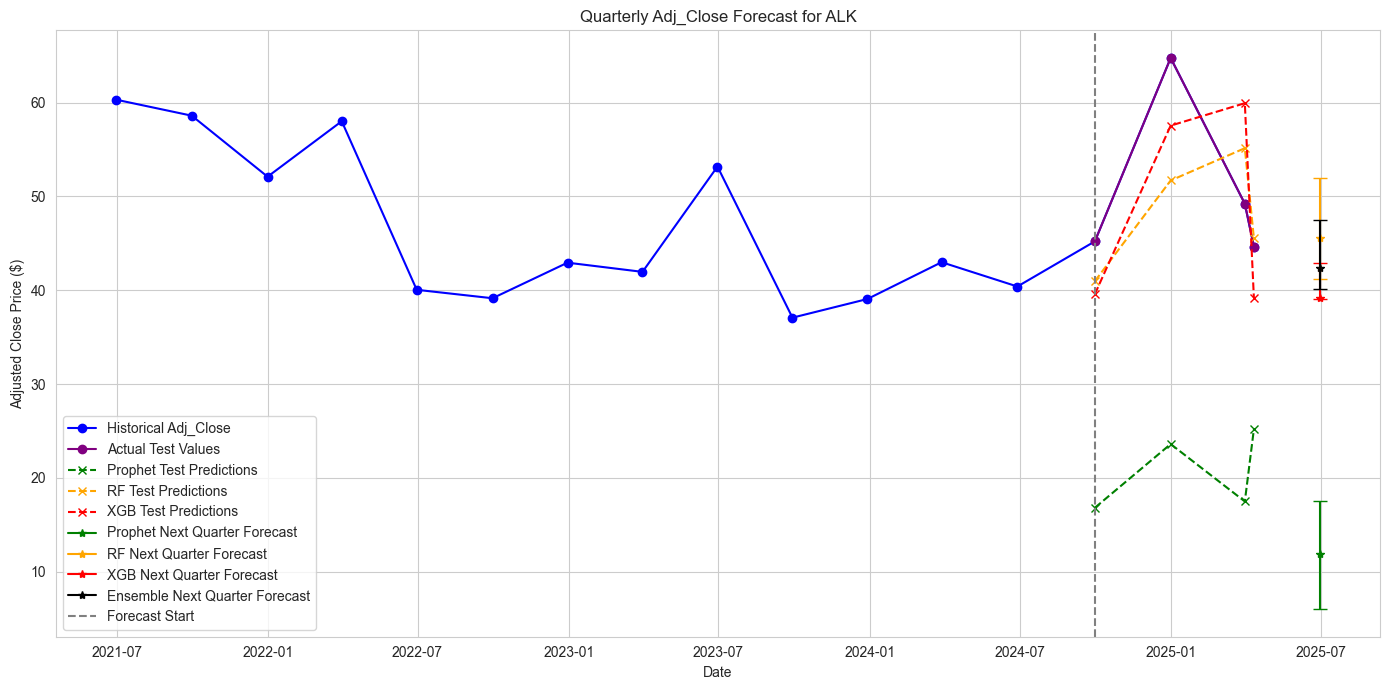

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# ------------------- Data Acquisition & Preprocessing -------------------

# Define the ticker symbol
ticker_symbol = 'ALK'

# Download historical data (5 years for more data)
print("Downloading historical data for", ticker_symbol)
df = yf.download(ticker_symbol, period='5y', interval='1d', auto_adjust=False)

# Reset index to make 'Date' a column
df.reset_index(inplace=True)

# Debug: Print columns after download
print("Columns after yf.download:", df.columns.tolist())

# Convert 'Date' to datetime (yfinance daily data is timezone-naive)
df['Date'] = pd.to_datetime(df['Date'])

# Handle MultiIndex if present (flatten columns)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

# Debug: Print columns after flattening
print("Columns after flattening:", df.columns.tolist())

# Rename columns for consistency
df = df.rename(columns={'Close': 'Raw_Close', 'Adj Close': 'Adj_Close'})

# Debug: Print columns after renaming
print("Columns after renaming:", df.columns.tolist())

# Verify required columns exist
required_columns = ['Date', 'Open', 'High', 'Low', 'Raw_Close', 'Adj_Close', 'Volume']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise KeyError(f"Missing columns: {missing_columns}")

# Select relevant columns
df = df[required_columns]

# Sort data by Date to ensure chronological order
df = df.sort_values(by='Date')

# ------------------- Data Aggregation to Quarterly Frequency -------------------

# Assign each date to its corresponding quarter
df['Quarter'] = df['Date'].dt.to_period('Q')

# Aggregate data to quarterly frequency
df_quarterly = df.groupby('Quarter').agg({
    'Date': 'last',
    'Adj_Close': 'last',
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Volume': 'sum'
}).reset_index(drop=True)

# Convert 'Date' back to datetime for plotting
df_quarterly['Date'] = pd.to_datetime(df_quarterly['Date'])

# ------------------- Feature Engineering -------------------

# Create lagged features
df_quarterly['Prev_Adj_Close'] = df_quarterly['Adj_Close'].shift(1)
df_quarterly['Price_Change'] = df_quarterly['Adj_Close'] - df_quarterly['Prev_Adj_Close']
df_quarterly['High_Low_Spread'] = df_quarterly['High'] - df_quarterly['Low']
df_quarterly['Volatility'] = df_quarterly['Adj_Close'].rolling(window=4).std().shift(1)
df_quarterly['Volume_Change'] = df_quarterly['Volume'].diff()
df_quarterly['Momentum'] = df_quarterly['Adj_Close'].diff(2)

# Add technical indicators
df_quarterly['MA_2Q'] = df_quarterly['Adj_Close'].rolling(window=2).mean().shift(1)
delta = df_quarterly['Adj_Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=2).mean().shift(1)
loss = (-delta.where(delta < 0, 0)).rolling(window=2).mean().shift(1)
rs = gain / loss
df_quarterly['RSI'] = 100 - (100 / (1 + rs))

# Add Bollinger Bands (simplified for quarterly data)
df_quarterly['MA_4Q'] = df_quarterly['Adj_Close'].rolling(window=4).mean().shift(1)
df_quarterly['BB_Upper'] = df_quarterly['MA_4Q'] + 2 * df_quarterly['Volatility']
df_quarterly['BB_Lower'] = df_quarterly['MA_4Q'] - 2 * df_quarterly['Volatility']

# Add MACD (simplified for quarterly data)
df_quarterly['EMA_2Q'] = df_quarterly['Adj_Close'].ewm(span=2, adjust=False).mean().shift(1)
df_quarterly['EMA_4Q'] = df_quarterly['Adj_Close'].ewm(span=4, adjust=False).mean().shift(1)
df_quarterly['MACD'] = df_quarterly['EMA_2Q'] - df_quarterly['EMA_4Q']

# Drop rows with NaN values
df_quarterly = df_quarterly.dropna().reset_index(drop=True)

# Check if there's enough data
if len(df_quarterly) < 4:
    raise ValueError("Not enough data after preprocessing. Consider increasing the period.")

# Define features and target
features = ['Open', 'High', 'Low', 'Volume', 'Prev_Adj_Close', 'Price_Change', 
            'High_Low_Spread', 'Volatility', 'Volume_Change', 'Momentum', 
            'MA_2Q', 'RSI', 'BB_Upper', 'BB_Lower', 'MACD']
X = df_quarterly[features]
y = df_quarterly['Adj_Close']

# ------------------- Data Preparation for Modeling -------------------

# Scale features for models
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Perform time-series split
split_index = int(len(X) * 0.8)
if split_index == len(X):
    split_index -= 1
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]
dates_train = df_quarterly['Date'].iloc[:split_index]
dates_test = df_quarterly['Date'].iloc[split_index:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# ------------------- Prophet Model for Time-Series Forecasting -------------------

# Prepare data for Prophet
prophet_df = df_quarterly[['Date', 'Adj_Close']].rename(columns={'Date': 'ds', 'Adj_Close': 'y'})
prophet_train = prophet_df.iloc[:split_index]
prophet_test = prophet_df.iloc[split_index:]

# Initialize and train Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(prophet_train)

# ------------------- Random Forest and XGBoost Models -------------------

# Initialize regression models with tuned parameters
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
xgb_model = XGBRegressor(max_depth=3, learning_rate=0.1, random_state=42)

# Train the models
print("Training Random Forest and XGBoost models...")
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# ------------------- Model Evaluation -------------------

# Prophet predictions on test set
future_test = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='Q')
forecast_test = prophet_model.predict(future_test)
y_pred_prophet = forecast_test['yhat'].iloc[split_index:].values

# Random Forest and XGBoost predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate regression metrics
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n{model_name} Performance Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

calculate_metrics(y_test, y_pred_prophet, "Prophet")
calculate_metrics(y_test, y_pred_rf, "Random Forest")
calculate_metrics(y_test, y_pred_xgb, "XGBoost")

# ------------------- Forecasting Next Quarter -------------------

# Prophet forecast for the next quarter
future = prophet_model.make_future_dataframe(periods=len(prophet_test) + 1, freq='Q')
forecast = prophet_model.predict(future)
next_pred_prophet = forecast['yhat'].iloc[-1]
prophet_lower = forecast['yhat_lower'].iloc[-1]
prophet_upper = forecast['yhat_upper'].iloc[-1]

# Random Forest and XGBoost forecasts
last_row = df_quarterly.iloc[-1]
last_features = last_row[features].values.reshape(1, -1)
next_pred_rf = rf_model.predict(last_features)[0]
next_pred_xgb = xgb_model.predict(last_features)[0]

# Estimate confidence intervals for RF and XGB using bootstrap
n_bootstrap = 100
rf_predictions = []
xgb_predictions = []
for _ in range(n_bootstrap):
    indices = np.random.choice(len(X_train), len(X_train), replace=True)
    rf_bootstrap = RandomForestRegressor(n_estimators=50, random_state=42)
    xgb_bootstrap = XGBRegressor(max_depth=3, learning_rate=0.1, random_state=42)
    rf_bootstrap.fit(X_train.iloc[indices], y_train.iloc[indices])
    xgb_bootstrap.fit(X_train.iloc[indices], y_train.iloc[indices])
    rf_predictions.append(rf_bootstrap.predict(last_features)[0])
    xgb_predictions.append(xgb_bootstrap.predict(last_features)[0])

rf_lower, rf_upper = np.percentile(rf_predictions, [5, 95])
xgb_lower, xgb_upper = np.percentile(xgb_predictions, [5, 95])

# Ensemble prediction (average of RF and XGB)
next_pred_ensemble = (next_pred_rf + next_pred_xgb) / 2
ensemble_lower = (rf_lower + xgb_lower) / 2
ensemble_upper = (rf_upper + xgb_upper) / 2

# Get the last date and calculate the next quarter's date
last_date = df_quarterly['Date'].max()
next_quarter_date = last_date + pd.offsets.QuarterEnd(1)

print("\nNext Quarter Forecasted Adj_Close:")
print(f"Prophet: ${next_pred_prophet:.2f} (CI: ${prophet_lower:.2f} - ${prophet_upper:.2f})")
print(f"Random Forest: ${next_pred_rf:.2f} (CI: ${rf_lower:.2f} - ${rf_upper:.2f})")
print(f"XGBoost: ${next_pred_xgb:.2f} (CI: ${xgb_lower:.2f} - ${xgb_upper:.2f})")
print(f"Ensemble (RF + XGB): ${next_pred_ensemble:.2f} (CI: ${ensemble_lower:.2f} - ${ensemble_upper:.2f})")

# ------------------- Visualization -------------------

# Prepare data for plotting
historical_dates = df_quarterly['Date']
historical_adj_close = df_quarterly['Adj_Close']

# Combine test predictions with dates
test_df = pd.DataFrame({
    'Date': dates_test,
    'Actual': y_test,
    'Prophet_Pred': y_pred_prophet,
    'RF_Pred': y_pred_rf,
    'XGB_Pred': y_pred_xgb
})

# Create forecast DataFrame for the next quarter
forecast_df = pd.DataFrame({
    'Date': [next_quarter_date],
    'Prophet_Pred': [next_pred_prophet],
    'RF_Pred': [next_pred_rf],
    'XGB_Pred': [next_pred_xgb],
    'Ensemble_Pred': [next_pred_ensemble]
})

# Plot historical data and forecasts
plt.figure(figsize=(14, 7))
plt.plot(historical_dates, historical_adj_close, label='Historical Adj_Close', marker='o', color='blue')
plt.plot(test_df['Date'], test_df['Actual'], label='Actual Test Values', marker='o', linestyle='-', color='purple')
plt.plot(test_df['Date'], test_df['Prophet_Pred'], label='Prophet Test Predictions', marker='x', linestyle='--', color='green')
plt.plot(test_df['Date'], test_df['RF_Pred'], label='RF Test Predictions', marker='x', linestyle='--', color='orange')
plt.plot(test_df['Date'], test_df['XGB_Pred'], label='XGB Test Predictions', marker='x', linestyle='--', color='red')
plt.plot(forecast_df['Date'], forecast_df['Prophet_Pred'], marker='*', color='green', label='Prophet Next Quarter Forecast')
plt.plot(forecast_df['Date'], forecast_df['RF_Pred'], marker='*', color='orange', label='RF Next Quarter Forecast')
plt.plot(forecast_df['Date'], forecast_df['XGB_Pred'], marker='*', color='red', label='XGB Next Quarter Forecast')
plt.plot(forecast_df['Date'], forecast_df['Ensemble_Pred'], marker='*', color='black', label='Ensemble Next Quarter Forecast')

# Add confidence intervals
plt.errorbar(forecast_df['Date'], forecast_df['Prophet_Pred'], yerr=[[next_pred_prophet - prophet_lower], [prophet_upper - next_pred_prophet]], fmt='none', color='green', capsize=5)
plt.errorbar(forecast_df['Date'], forecast_df['RF_Pred'], yerr=[[next_pred_rf - rf_lower], [rf_upper - next_pred_rf]], fmt='none', color='orange', capsize=5)
plt.errorbar(forecast_df['Date'], forecast_df['XGB_Pred'], yerr=[[next_pred_xgb - xgb_lower], [xgb_upper - next_pred_xgb]], fmt='none', color='red', capsize=5)
plt.errorbar(forecast_df['Date'], forecast_df['Ensemble_Pred'], yerr=[[next_pred_ensemble - ensemble_lower], [ensemble_upper - next_pred_ensemble]], fmt='none', color='black', capsize=5)

# Highlight the forecast period
plt.axvline(x=dates_test.min(), color='gray', linestyle='--', label='Forecast Start')

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.title(f'Quarterly Adj_Close Forecast for {ticker_symbol}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()